<a href="https://colab.research.google.com/github/kapitalistka/SberSchoolGroupProject/blob/main/%D0%93%D1%80%D1%83%D0%BF%D0%BF%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Групповой проект 2
[Соревнование на Kaggle](https://www.kaggle.com/c/ieee-fraud-detection/overview)
In this competition you are predicting the probability that an online transaction is fraudulent, as denoted by the binary target isFraud.

The data is broken into two files identity and transaction, which are joined by TransactionID. Not all transactions have corresponding identity information. 

Детекция мошеннических операций. Предсказание мошенничества крайне актуальная задача в современных финансовых организациях. Обратите внимание на несбалансированность классов. Это может стать большой проблемой при решении.

Categorical Features - Transaction
*   ProductCD
*   card1
*   card6
*   addr1
*   addr2
*   P_emaildomain
*   R_emaildomain
*   M1 - M9

Categorical Features - Identity
*   DeviceType
*   DeviceInfo
*   id_01 - id_38

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp).

## Все импорты ноутбука здесь

In [ ]:
!pip install -q catboost shap

     |████████████████████████████████| 76.1 MB 40.2 MB/s 
     |████████████████████████████████| 564 kB 34.5 MB/s 


In [ ]:
import catboost as cb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.linear_model import LogisticRegression, SGDClassifier, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import zipfile
import random
import os
import gc
from functools import partial
import requests
import io
import base64
import pickle
import sys

# Анализ данных

##Выгрузка из Kaggle

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [ ]:
!kaggle competitions download -c ieee-fraud-detection -p kaggle/

  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 28.1MB/s]
 87% 51.0M/58.3M [00:01<00:00, 52.4MB/s]
100% 58.3M/58.3M [00:01<00:00, 53.8MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 38.0MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 228MB/s]
 84% 44.0M/52.2M [00:02<00:00, 15.2MB/s]
100% 52.2M/52.2M [00:02<00:00, 22.6MB/s]


In [ ]:
!unzip data-science-for-good.zip

unzip:  cannot find or open data-science-for-good.zip, data-science-for-good.zip.zip or data-science-for-good.zip.ZIP.


In [ ]:
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         76           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        116           False  
store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        848           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        173           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       1835           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      14041           False  
house-pr

In [ ]:
path_to_data = '/content/kaggle/test_identity.csv.zip'
test_ident = pd.read_csv(path_to_data)
test_ident.head()

In [ ]:
path_to_data = '/content/kaggle/test_transaction.csv.zip'
test_transaction = pd.read_csv(path_to_data)


In [ ]:
path_to_data = '/content/kaggle/train_identity.csv.zip'
train_identity = pd.read_csv(path_to_data)
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
path_to_data = '/content/kaggle/train_transaction.csv.zip'
train_transaction = pd.read_csv(path_to_data)

In [ ]:
test_transaction.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,47.950001,0.000000,0.000000,47.950001,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,280.000000,77.000000,0.000000,280.000000,0.000000,77.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,1321.000000,0.000000,0.000000,1058.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,282.540009,282.540009,282.540009,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,0.0,0.0,0.0,0.0,0.0,1.0,67.949997,183.850006,67.949997,67.949997,183.850006,67.949997,67.949997,67.949997,183.850006,67.949997,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
del train_identity
del train_transaction

In [ ]:
del test_ident
del test_transaction

In [ ]:
gc.collect()

139

In [ ]:
list_of_test_ident=test_ident.TransactionID

In [ ]:
list_of_test_ident.to_csv('/content/drive/MyDrive/Classroom/list_of_test_ident.csv', index=False)

In [ ]:
data_test_short=pd.merge(test_transaction, test_ident, on='TransactionID')

In [ ]:
test_transaction.shape, train_transaction.shape

((506691, 393), (590540, 394))

In [ ]:
test_ident.shape, train_identity.shape

((141907, 41), (144233, 41))

In [ ]:
data_train_full=pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [ ]:
data_test=pd.merge(test_transaction, test_ident, on='TransactionID', how='left')

##Выгрузка на Google disk

In [ ]:
#data_test.to_csv('/content/drive/MyDrive/Classroom/data_test_isFraud_31_01.csv', index=False)

In [ ]:
#data_train_full.to_csv('/content/drive/MyDrive/Classroom/data_train_full_isFraud_31_01.csv', index=False)

In [ ]:
#data_train.to_csv('/content/drive/MyDrive/Classroom/data_train_isFraud_31_01.csv', index=False)

In [ ]:
#data_test_short.to_csv('/content/drive/MyDrive/Classroom/data_test_short_isFraud_31_01.csv', index=False)

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_test_isFraud_31_01.csv'
data_test = pd.read_csv(path_to_data)
data_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_train_isFraud_31_01.csv'
data_train = pd.read_csv(path_to_data)
data_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,credit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,83.0,0.0,...,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,30.0,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,...,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,debit,170.0,87.0,NaN,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,26.0,0.0,...,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_train_full_isFraud_31_01.csv'
data_train_full = pd.read_csv(path_to_data)
data_train_full.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_test_short_isFraud_31_01.csv'
data_test_short = pd.read_csv(path_to_data)
data_test_short.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663586,18404013,6.271,C,15885,545.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,...,-45.0,280290.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
1,3663588,18404055,50.000,S,2453,399.0,150.0,american express,137.0,credit,494.0,87.0,NaN,37.0,NaN,gmail.com,4.0,8.0,0.0,4.0,0.0,0.0,0.0,25.0,0.0,30.0,5.0,0.0,57.0,4.0,34.0,34.0,1.0,NaN,NaN,634.0,1.0,22.0,0.0,458.0,...,0.0,3579.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,NaN,542.0,368.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android 6.0.1,chrome 67.0 for android,24.0,1280x720,match_status:2,T,F,T,T,mobile,LGLS676 Build/MXB48T
2,3663597,18404235,37.318,C,15885,545.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,anonymous.com,anonymous.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,...,-5.0,185210.0,NaN,NaN,1.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,-360.0,New,NotFound,225.0,NaN,271.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,ie 11.0 for tablet,NaN,NaN,NaN,F,T,T,F,desktop,Trident/7.0
3,3663601,18404315,6.271,C,15885,545.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,2.0,4.0,0.0,3.0,0.0,3.0,3.0,3.0,0.0,3.0,3.0,3.0,2.0,1.0,NaN,NaN,0.0,567.0,288.0,567.0,288.0,0.0,0.0,0.0,...,-45.0,252944.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,27.0,NaN,Found,Found,225.0,15.0,427.0,563.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,MYA-L13 Build/HUAWEIMYA-L13
4,3663602,18404359,52.258,C,9633,130.0,185.0,visa,138.0,debit,NaN,NaN,NaN,NaN,hotmail.com,hotmail.com,8.0,21.0,0.0,4.0,0.0,4.0,4.0,5.0,0.0,6.0,11.0,11.0,10.0,6.0,NaN,NaN,NaN,316.0,2.0,316.0,2.0,NaN,NaN,0.0,...,-95.0,328680.0,NaN,NaN,7.0,-33.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,567.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 67.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,SM-G9650 Build/R16NW


In [ ]:
data_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0,86506,50.000,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,0,86535,15.000,H,2803,100.0,150.0,visa,226.0,debit,337.0,87.0,NaN,NaN,anonymous.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,0,86549,75.887,C,16496,352.0,117.0,mastercard,134.0,credit,NaN,NaN,NaN,NaN,gmail.com,gmail.com,1.0,4.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,83.0,0.0,...,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,0,86555,16.495,C,4461,375.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,30.0,hotmail.com,hotmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,...,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0,86620,30.000,H,1790,555.0,150.0,visa,226.0,debit,170.0,87.0,NaN,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,26.0,0.0,...,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [ ]:
data_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
del data_train
del train_transaction

In [ ]:
del data_test
del data_test_short

In [ ]:
gc.collect()

139

## Подготовка графиков

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_train_full_isFraud_03_02_reduced.csv'
data = pd.read_csv(path_to_data,  usecols=card_feature)
data.head()

,card1,card2,card3,card4,card5,card6
0,13926,NaN,150.0,discover,142.0,credit
1,2755,404.0,150.0,mastercard,102.0,credit
2,4663,490.0,150.0,visa,166.0,debit
3,18132,567.0,150.0,mastercard,117.0,debit
4,4497,514.0,150.0,mastercard,102.0,credit


## Посмотрим на адреса

In [ ]:
for col in addr_feature:
  print(col, len(data_adr[col].unique()))

addr1 333
addr2 75


In [ ]:
for col in addr_feature:
  print(col, data_adr[col].value_counts())

addr1 299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
         ...  
386.0        1
101.0        1
353.0        1
516.0        1
245.0        1
Name: addr1, Length: 332, dtype: int64
addr2 87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
         ...  
49.0         1
14.0         1
25.0         1
22.0         1
93.0         1
Name: addr2, Length: 74, dtype: int64


Построим график с адресами

In [ ]:
city=data_adr.addr1.value_counts()
ranges = [0, 1000, 2000, 5000, 20000, 50000]
labels = ['Other','Small_towns', 'Towns','City','Big_city']
citybins=(pd.cut(city, ranges,labels=labels))
# citybins.rename(columns={'addr1':'city'}, inplace=True)
# city=data_adr.addr1.value_counts()
city.name='Quantity'
city=pd.DataFrame(city).reset_index()
city['city']=pd.Series(city['index']).map(citybins)
city.head(5)

,index,Quantity,city
0,299.0,46335,Big_city
1,325.0,42751,Big_city
2,204.0,42020,Big_city
3,264.0,39870,Big_city
4,330.0,26287,Big_city


In [ ]:
city.groupby(['city'])['Quantity'].sum().reset_index()

,city,Quantity
0,Other,19669
1,Small_towns,37210
2,Towns,116154
3,City,90492
4,Big_city,261309


График по количеству операций по городам

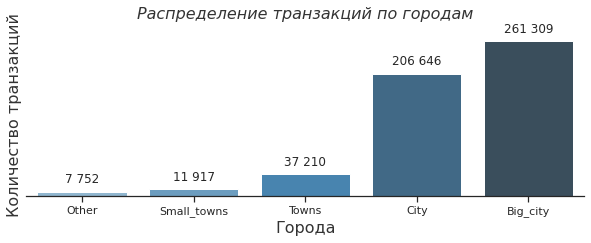

In [ ]:
plt.figure(figsize=(10,3))
annot = {'fontdict' :{'fontsize' :15},'rotation':90}
custom_params = {"axes.spines.right": False, "axes.spines.top": False,
                 "axes.spines.left": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.barplot(x='city', y='Quantity', data=city.groupby(['city'])['Quantity']\
                 .sum().reset_index(), palette='Blues_d')
for z in ax.patches: 
  ax.annotate('{0:,.0f}'.format(z.get_height()).replace(',', ' ') , 
                   (z.get_x() + z.get_width() / 2., z.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 12), 
                   size=12, 
                   textcoords = 'offset points')
plt.xlabel('Города', size = 16, color='0.2')
ax.set_yticklabels([])
plt.yticks([]) 
plt.ylabel('Количество транзакций', size = 16, color='0.2')
plt.title('Распределение транзакций по городам', size = 16, y=1.05,
          fontstyle='oblique', color='0.2' );

График по составу корзин

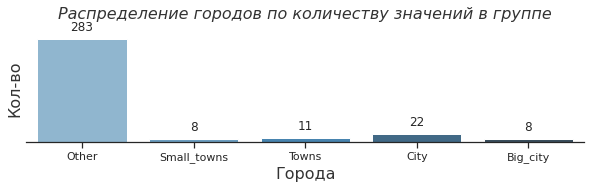

In [ ]:
plt.figure(figsize=(10,2))
annot = {'fontdict' :{'fontsize' :15},'rotation':90}
custom_params = {"axes.spines.right": False, "axes.spines.top": False,
                 "axes.spines.left": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.countplot(x='city', data=city, palette='Blues_d')
for z in ax.patches: 
  ax.annotate('{0:,.0f}'.format(z.get_height()).replace(',', ' ') , 
                   (z.get_x() + z.get_width() / 2., z.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 12), 
                   size=12, 
                   textcoords = 'offset points')
plt.xlabel('Города', size = 16, color='0.2')
ax.set_yticklabels([])
plt.yticks([]) 
plt.ylabel('Кол-во', size = 16, color='0.2')
plt.title('Распределение городов по количеству значений в группе', size = 16, y=1.08,
          fontstyle='oblique', color='0.2' );

In [ ]:
for col in addr_feature:
  print(col, data_adr[col].isna().sum()/data_adr.shape[0])

addr1 0.1112642666034477
addr2 0.1112642666034477


Построим график по странам

In [ ]:
country=pd.Series(data=['USA'], index=[87.])
data_adr['country']=pd.Series(data_adr.addr2).map(country)
data_adr['country'].fillna('Other', inplace=True)

In [ ]:
data_adr

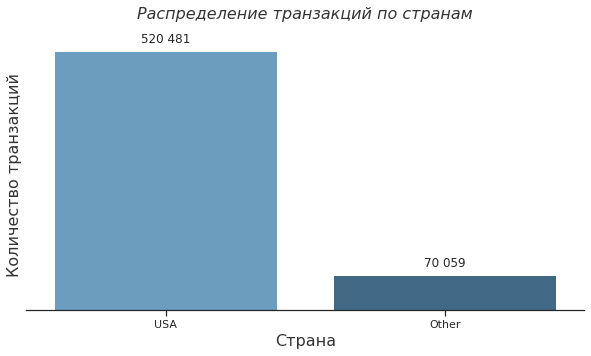

In [ ]:
plt.figure(figsize=(10,5))
annot = {'fontdict' :{'fontsize' :15},'rotation':90}
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.countplot(x='country', data=data_adr, palette='Blues_d')
for z in ax.patches: 
  ax.annotate('{0:,}'.format(z.get_height()).replace(',', ' ') , 
                   (z.get_x() + z.get_width() / 2., z.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 12), 
                   size=12, 
                   textcoords = 'offset points')
plt.xlabel('Страна', size = 16, color='0.2')
ax.set_yticklabels([])
plt.yticks([]) 
plt.ylabel('Количество транзакций', size = 16, color='0.2')
plt.title('Распределение транзакций по странам', size = 16, y=1.05, fontstyle='oblique', color='0.2' );

##Проанализируем сумму операции

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_train_full_isFraud_03_02_reduced.csv'
data = pd.read_csv(path_to_data,  usecols=['isFraud', 'TransactionAmt'])
data.head()

,isFraud,TransactionAmt
0,0,68.5
1,0,29.0
2,0,59.0
3,0,50.0
4,0,50.0


In [ ]:
data.shape

(590540, 2)

In [ ]:
ranges = [0, 100, 500, 1000, 5000, 10000, 50000]
labels = ['100usd&less','100-500usd', '500-1000usd','1000-5000usd','5000-1000usd', '10000usd&more']
data['Sum_bins']=(pd.cut(pd.Series(data.TransactionAmt), ranges, labels=labels))

In [ ]:
data.head(5)

,TransactionAmt,isFraud,Sum_bins
0,68.5,0,100usd&less
1,29.0,0,100usd&less
2,59.0,0,100usd&less
3,50.0,0,100usd&less
4,50.0,0,100usd&less


In [ ]:
data_gr=data[data['TransactionAmt']<=500.].copy()

In [ ]:
ranges = [0, 100, 500]
labels = ['100usd&less','100-500usd']
data_gr['Sum_bins']=(pd.cut(pd.Series(data.TransactionAmt), ranges, labels=labels))

In [ ]:
data_gr=data_gr.groupby(['Sum_bins', 'isFraud'])['TransactionAmt'].mean()

In [ ]:
data_gr=data_gr.unstack()

In [ ]:
data_gr=data_gr.reset_index()

In [ ]:
data_gr

,Sum_bins,isFraud,TransactionAmt
0,100usd&less,0,50.775366
1,100usd&less,1,46.247395
2,100-500usd,0,189.447583
3,100-500usd,1,222.054808


In [ ]:
data_gr=data_gr.groupby(['Sum_bins', 'isFraud'])['TransactionAmt'].mean()

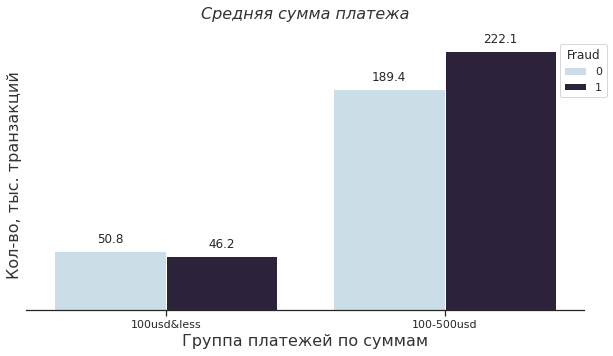

In [ ]:
plt.figure(figsize=(10,5))
annot = {'fontdict' :{'fontsize' :15},'rotation':90}
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.barplot(x='Sum_bins',
                 y='TransactionAmt', 
                  hue='isFraud',
                 data=data_gr, palette='ch:s=.25,rot=-.25')
for z in ax.patches: 
  ax.annotate('{0:,}'.format(round(z.get_height(),1)).replace(',', ' ') , 
                   (z.get_x() + z.get_width() / 2., z.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 12), 
                   size=12, 
                   textcoords = 'offset points')
plt.xlabel('Группа платежей по суммам', size = 16, color='0.2')
ax.set_yticklabels([])
plt.yticks([]) 
plt.ylabel('Кол-во, тыс. транзакций', size = 16, color='0.2')
plt.legend(loc='upper right', bbox_to_anchor=(1.05,1), title='Fraud')
plt.title('Средняя сумма платежа', size = 16, y=1.05, fontstyle='oblique', color='0.2' );

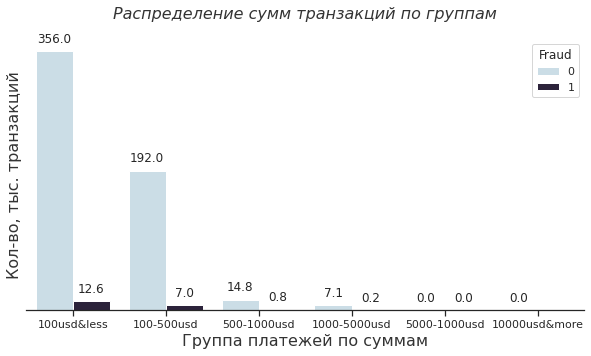

In [ ]:
plt.figure(figsize=(10,5))
annot = {'fontdict' :{'fontsize' :15},'rotation':90}
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.countplot(x='Sum_bins', 
                  hue='isFraud',
                 data=data, palette='ch:s=.25,rot=-.25')
for z in ax.patches: 
  ax.annotate('{0:,}'.format(round(z.get_height()/1000,1)).replace(',', ' ') , 
                   (z.get_x() + z.get_width() / 2., z.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 12), 
                   size=12, 
                   textcoords = 'offset points')
plt.xlabel('Группа платежей по суммам', size = 16, color='0.2')
ax.set_yticklabels([])
plt.yticks([]) 
plt.ylabel('Кол-во, тыс. транзакций', size = 16, color='0.2')
plt.legend(loc='upper right', bbox_to_anchor=(1,1), title='Fraud')
plt.title('Распределение сумм транзакций по группам', size = 16, y=1.05, fontstyle='oblique', color='0.2' );

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

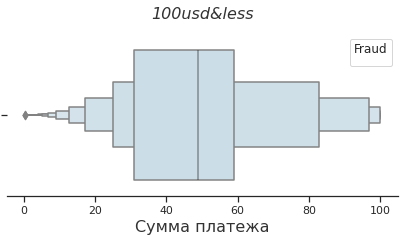

No handles with labels found to put in legend.


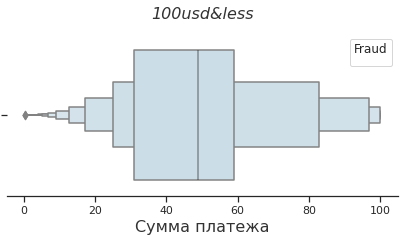

No handles with labels found to put in legend.


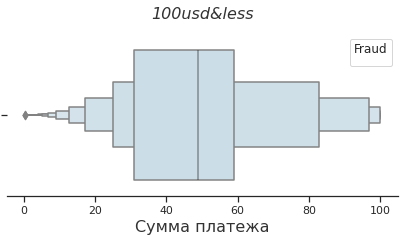

No handles with labels found to put in legend.


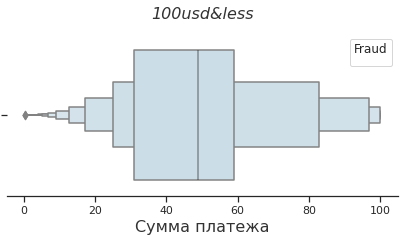

No handles with labels found to put in legend.


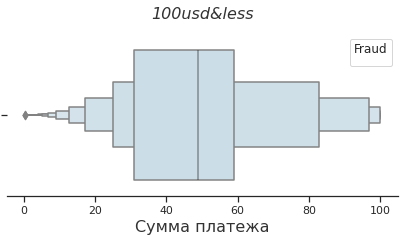

No handles with labels found to put in legend.


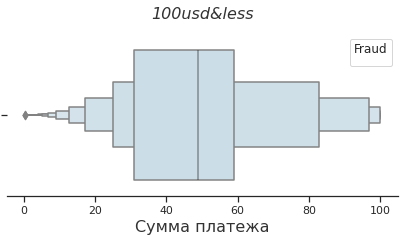

In [ ]:
annot = {'fontdict' :{'fontsize' :15},'rotation':90}
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
sns.set_theme(style="ticks", rc=custom_params)
# fig=
plt.figure()
axes=fig.subplots(7, 1, sharex=True, sharey=True)
i=1
for val in data['Sum_bins'].unique():
  plt.figure(figsize=(7,3))
  # plt.subplot(3,2,i)
  axes[i] = sns.boxenplot(# x='Sum_bins',
                 x='TransactionAmt',
                  y='isFraud',
                 data=data[data['Sum_bins']==val],
                 palette='ch:s=.25,rot=-.25')
  for z in ax.patches: 
    ax.annotate('{0:,}'.format(z.get_height()).replace(',', ' ') , 
                   (z.get_x() + z.get_width() / 2., z.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 12), 
                   size=12, 
                   textcoords = 'offset points')
  plt.xlabel('Сумма платежа', size = 16, color='0.2')
  # plt.ylabel('Сумма транзакций', size = 16, color='0.2')
  plt.legend(loc='upper right', bbox_to_anchor=(1,1), title='Fraud')
  plt.title(val, size = 16, y=1.05, fontstyle='oblique', color='0.2' )
  plt.show()
  plt.close();
  i+=1
  if i>6:
    break


/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1319: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))


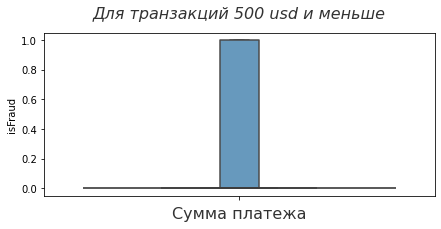

In [ ]:
plt.figure(figsize=(7,3))
# val='100-500usd'
data_graf=data.query('TransactionAmt<500')[['TransactionAmt', 'isFraud']]
ax = sns.boxenplot(y='isFraud',
                 data=data_graf,
                 orient='h',
                 palette='Blues_d')
plt.xlabel('Сумма платежа', size = 16, color='0.2')
plt.title("Для транзакций 500 usd и меньше", size = 16, y=1.05, fontstyle='oblique', color='0.2' );

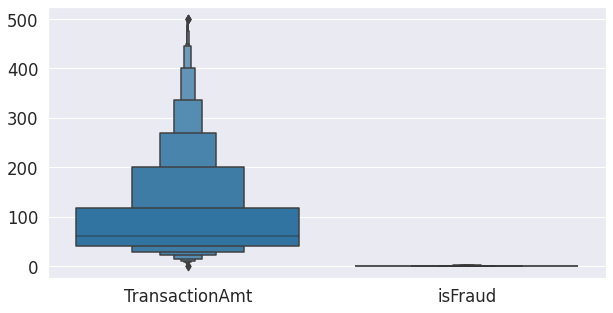

In [ ]:
with sns.plotting_context('notebook', font_scale=1.5), \
    sns.axes_style('darkgrid'):
      plt.figure(figsize=(10, 5))
      data=data.query('TransactionAmt<500')[['TransactionAmt', 'isFraud']]
      ax=sns.boxenplot(data=data)

In [ ]:
del data

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_train_full_isFraud_03_02_reduced.csv'
data = pd.read_csv(path_to_data,  usecols=['TransactionDT', 'TransactionAmt', 'isFraud'])
data.head()

,isFraud,TransactionDT,TransactionAmt
0,0,86400,68.5
1,0,86401,29.0
2,0,86469,59.0
3,0,86499,50.0
4,0,86506,50.0


In [ ]:
# with sns.plotting_context('notebook', font_scale=1.5), \
#     sns.axes_style('darkgrid'):
lab='Мошеннические операции среди обычных транзакций'+'/n'+'в разрезе сумм и дат операций')
annot = {'fontdict' :{'fontsize' :15},'rotation':90}
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
sns.set_theme(style="ticks", rc=custom_params)
plt.figure(figsize=(10, 5))
ax=sns.scatterplot(x='TransactionDT', y='TransactionAmt',\
                data=data.query('TransactionAmt<5000'),\
                hue='isFraud', alpha=0.6)
plt.xlabel('TransactionDT', size = 16, color='0.2')
plt.ylabel('Сумма транзакций', size = 16, color='0.2')
plt.legend(loc='upper right', bbox_to_anchor=(1,1), title='Fraud')
plt.title(label=('Мошеннические операции среди обычных транзакций',end='/n','в разрезе сумм и дат операций'),\
          size = 16, y=1.05, fontstyle='oblique', color='0.2' )
plt.show()

SyntaxError: ignored

In [ ]:
lab=f'Мошеннические операции среди обычных транзакций/n в разрезе сумм и дат операций'
print(lab)

Мошеннические операции среди обычных транзакций/n в разрезе сумм и дат операций


In [ ]:
for col in card_feature:
  print(col, len(data[col].unique()))

card1 13553
card2 501
card3 115
card4 5
card5 120
card6 5


In [ ]:
card_4=data.card4.value_counts().reset_index()
card_4.head(5)

In [ ]:
q=data.shape[0]

Построим график распределения транзакций по платежным системам

In [ ]:
card_4['proz']=round(card_4['card4']/q, 4)*100

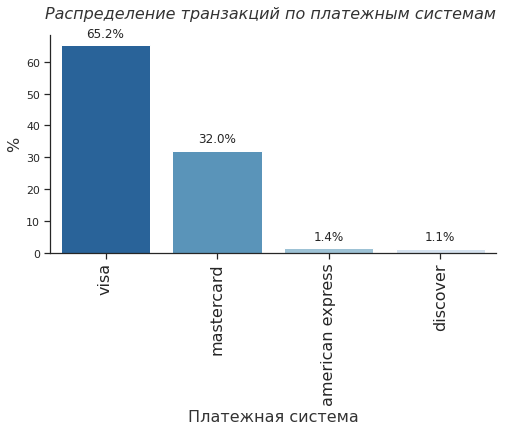

In [ ]:
# sns.set(context='notebook', style='white', font='sans-serif', palette='Blues_r', font_scale=1., color_codes=False,)
# palette=plt.get_cmap('Blues_r').reversed()
plt.figure(figsize=(8,4))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.barplot(x="index", y='proz',  data=card_4, palette='Blues_r')
for z in ax.patches: 
  ax.annotate(format(z.get_height(), '.1f') + '%', 
                   (z.get_x() + z.get_width() / 2., z.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 12), 
                   size=12, 
                   textcoords = 'offset points')
plt.xlabel('Платежная система', size = 16, color='0.2')
plt.xticks(rotation='vertical', size = 16,)
plt.ylabel('%', size = 16, color='0.2')
plt.title('Распределение транзакций по платежным системам ', size = 16, y=1.05, fontstyle='oblique', color='0.2' );

Построим график распределения транзакций по видам банковского продукта

In [ ]:
card_6=data.card6.value_counts().reset_index()
card_6['proz']=round(card_6['card6']/q, 4)*100

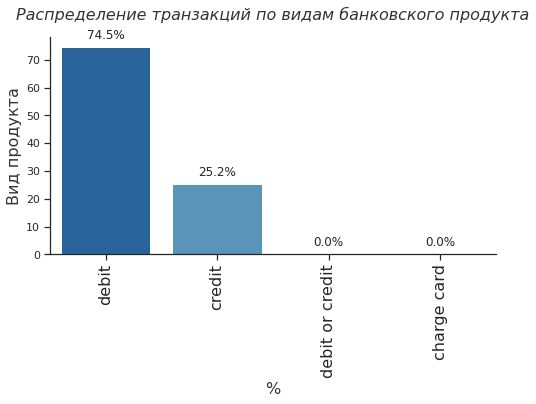

In [ ]:
plt.figure(figsize=(8,4))
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.barplot(x='index', y='proz', data=card_6,  palette='Blues_r')
for z in ax.patches: 
  ax.annotate(format(z.get_height(), '.1f') + '%', 
                   (z.get_x() + z.get_width() / 2., z.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 12), 
                   size=12, 
                   textcoords = 'offset points')
plt.xlabel('%', size = 16, color='0.2')
plt.xticks(rotation='vertical', size = 16,)
plt.ylabel('Вид продукта', size = 16, color='0.2')
plt.title('Распределение транзакций по видам банковского продукта', size = 16, y=1.05, fontstyle='oblique', color='0.2' );

In [ ]:
card6=data.card6.value_counts().reset_index()

In [ ]:
data.card3.value_counts()

150.0    521287
185.0     56346
106.0      1571
144.0      1252
146.0      1252
          ...  
224.0         1
199.0         1
221.0         1
209.0         1
173.0         1
Name: card3, Length: 114, dtype: int64

In [ ]:
del data
gc.collect()

##Анализ пропусков

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_train_full_isFraud_03_02_reduced.csv'
data = pd.read_csv(path_to_data,  usecols=features_cat_itog)
data.head()

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,NaN,T,T,T,M0,F,F,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
d.update({'d':5})

In [ ]:
d={}
for col in features_cat_itog:
  d.update({col:round(data[col].isna().sum()/data.shape[0]*100,2)})

In [ ]:
len(d)

45

In [ ]:
d

In [ ]:
df=pd.Series(d)

In [ ]:
df=pd.DataFrame(df).reset_index()
df.rename(columns={'index':'feature_name', 0:'percent_Nan'}, inplace=True)

In [ ]:
df=df.sort_values(by='percent_Nan')

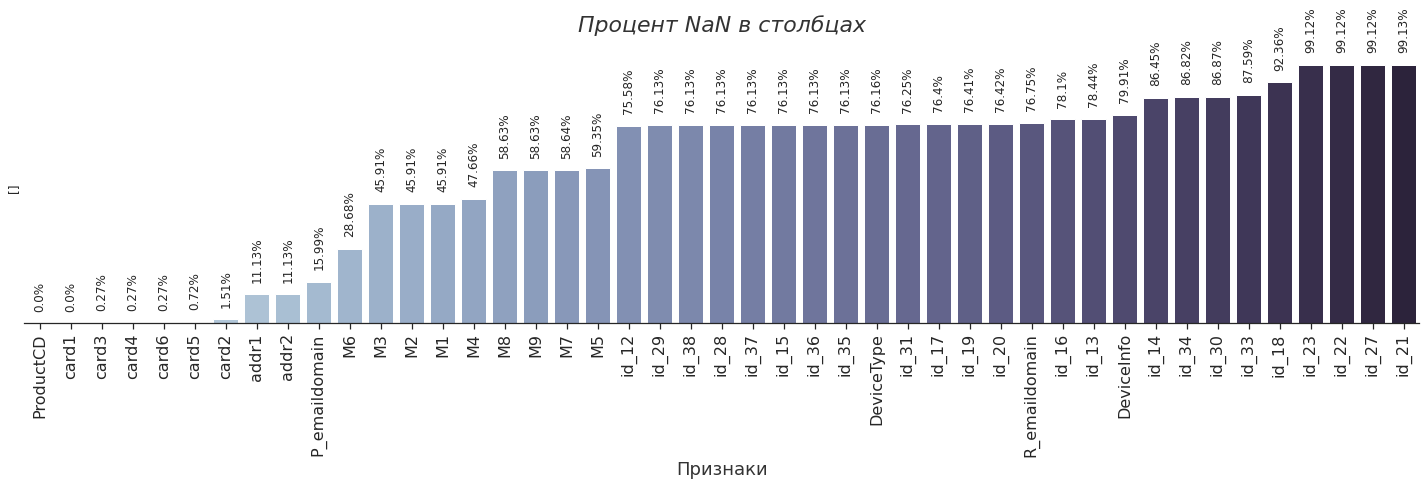

In [ ]:
plt.figure(figsize=(25,5))
annot = {'fontdict' :{'fontsize' :15},'rotation':90}
custom_params = {"axes.spines.right": False, "axes.spines.top": False, "axes.spines.left": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.barplot(x='feature_name', y='percent_Nan',         
                 data=df, palette='ch:s=.25,rot=-.25')
for z in ax.patches: 
  ax.annotate('{0:,}'.format(z.get_height())+'%' , 
                   (z.get_x() + z.get_width() / 2., z.get_height()), 
                   ha = 'center', va = 'bottom', 
                   xytext = (0, 12), 
                   size=12, 
                   textcoords = 'offset points', rotation='90')
plt.xlabel('Признаки', size = 18, color='0.2')
ax.set_yticklabels([])
plt.xticks(rotation='90',size = 16 )
plt.yticks([]) 
plt.ylabel([])
# plt.legend(loc='upper right', bbox_to_anchor=(1.05,1), title='Fraud')
plt.title('Процент NaN в столбцах', size = 22, y=1.05, fontstyle='oblique', color='0.2' );

In [ ]:
data['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [ ]:
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other',
          'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft',
          'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 
          'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other',
          'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo',
          'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo',
          'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo',
          'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo',
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other',
          'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple',
          'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other',
          'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}


In [ ]:
us_emails = ['gmail', 'net', 'edu']

In [ ]:
for c in ['P_emaildomain', 'R_emaildomain']:
    data[c + '_bin'] = data[c].map(emails)
    
    
    data[c + '_suffix'] = data[c].map(lambda x: str(x).split('.')[-1])
    
    
    data[c + '_suffix'] = data[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    

In [ ]:
data.head(5)

,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,P_emaildomain_bin,P_emaildomain_suffix,R_emaildomain_bin,R_emaildomain_suffix
0,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,nan
1,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,google,com,NaN,nan
2,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,outlook.com,NaN,T,T,T,M0,F,F,F,F,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,microsoft,com,NaN,nan
3,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,yahoo,com,NaN,nan
4,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,google,com,NaN,nan


In [ ]:
data

In [ ]:
def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

    return df
    

In [ ]:
del data

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_train_full_isFraud_03_02_reduced.csv'
data = pd.read_csv(path_to_data,  usecols=['TransactionDT', 'D1', 'D2', 'D3','D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14'])
data.head()

,TransactionDT,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14
0,86400,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN
1,86401,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2,86469,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN
3,86499,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN
4,86506,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
import datetime

In [ ]:
START_DATE = datetime.datetime.strptime('2017-11-30', '%Y-%m-%d')

In [ ]:
def setTime(df):
    df['TransactionDT'] = df['TransactionDT'].fillna(df['TransactionDT'].median())
    # Temporary
    df['DT'] = df['TransactionDT'].apply(lambda x: (START_DATE + datetime.timedelta(seconds = x)))
    df['DT_M'] = (df['DT'].dt.year-2017)*12 + df['DT'].dt.month
    df['DT_W'] = (df['DT'].dt.year-2017)*52 + df['DT'].dt.weekofyear
    df['DT_D'] = (df['DT'].dt.year-2017)*365 + df['DT'].dt.dayofyear
    
    df['DT_hour'] = df['DT'].dt.hour
    df['DT_day_week'] = df['DT'].dt.dayofweek
    df['DT_day'] = df['DT'].dt.day
    
    # Lets transform D8 and D9 column
    # As we almost sure it has connection with hours
    df['D9_not_na'] = np.where(df['D9'].isna(),0,1)
    df['D8_not_same_day'] = np.where(df['D8']>=1,1,0)
    df['D8_D9_decimal_dist'] = df['D8'].fillna(0)-df['D8'].fillna(0).astype(int)
    df['D8_D9_decimal_dist'] = ((df['D8_D9_decimal_dist']-df['D9'])**2)**0.5
    df['D8'] = df['D8'].fillna(-1).astype(int)

    return df
    

In [ ]:
setTime(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


,TransactionDT,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,DT,DT_M,DT_W,DT_D,DT_hour,DT_day_week,DT_day,D9_not_na,D8_not_same_day,D8_D9_decimal_dist
0,86400,14.0,NaN,13.0,NaN,NaN,NaN,NaN,-1,NaN,13.0,13.0,NaN,NaN,NaN,2017-12-01 00:00:00,12,48,335,0,4,1,0,0,NaN
1,86401,0.0,NaN,NaN,0.0,NaN,NaN,NaN,-1,NaN,0.0,NaN,NaN,NaN,NaN,2017-12-01 00:00:01,12,48,335,0,4,1,0,0,NaN
2,86469,0.0,NaN,NaN,0.0,NaN,NaN,NaN,-1,NaN,0.0,315.0,NaN,NaN,NaN,2017-12-01 00:01:09,12,48,335,0,4,1,0,0,NaN
3,86499,112.0,112.0,0.0,94.0,0.0,NaN,NaN,-1,NaN,84.0,NaN,NaN,NaN,NaN,2017-12-01 00:01:39,12,48,335,0,4,1,0,0,NaN
4,86506,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,2017-12-01 00:01:46,12,48,335,0,4,1,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,15811047,29.0,29.0,30.0,NaN,NaN,NaN,NaN,-1,NaN,56.0,56.0,NaN,NaN,NaN,2018-05-31 23:57:27,17,74,516,23,3,31,0,0,NaN
590536,15811049,0.0,NaN,NaN,0.0,NaN,NaN,NaN,-1,NaN,0.0,0.0,NaN,NaN,NaN,2018-05-31 23:57:29,17,74,516,23,3,31,0,0,NaN
590537,15811079,0.0,NaN,NaN,0.0,NaN,NaN,NaN,-1,NaN,0.0,0.0,NaN,NaN,NaN,2018-05-31 23:57:59,17,74,516,23,3,31,0,0,NaN
590538,15811088,22.0,22.0,0.0,22.0,0.0,NaN,NaN,-1,NaN,22.0,22.0,NaN,NaN,NaN,2018-05-31 23:58:08,17,74,516,23,3,31,0,0,NaN


In [ ]:
data['D1-D']

In [ ]:
('V17', 0.0),
 ('V59', 0.0),
 ('V80', 0.0),
 ('V81', 0.0),
 ('V101', 0.0),
 ('V106', 0.0),
 ('V115', 0.0),
 ('V141', 0.0),
 ('V153', 0.0),
 ('V154', 0.0),
 ('V169', 0.0),
 ('V171', 0.0),
 ('V176', 0.0),
 ('V182', 0.0),
 ('V186', 0.0),
 ('V196', 0.0),
 ('V198', 0.0),
 ('V205', 0.0),
 ('V212', 0.0),
 ('V216', 0.0),
 ('V226', 0.0),
 ('V232', 0.0),
 ('V254', 0.0),
 ('V275', 0.0),
 ('V299', 0.0),
 ('V326', 0.0),
 ('V334', 0.0)]

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_train_full_isFraud_03_02_reduced.csv'
data = pd.read_csv(path_to_data,  usecols=['P_emaildomain', 'card1', 'isFraud'])
data.head()

,isFraud,card1,P_emaildomain
0,0,13926,NaN
1,0,2755,gmail.com
2,0,4663,outlook.com
3,0,18132,yahoo.com
4,0,4497,gmail.com


In [ ]:
data.P_emaildomain.value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [ ]:
data['card_edom']=data['card1'].astype(str)+data['P_emaildomain']

In [ ]:
data['card_edom'].value_counts()

7919gmail.com       7041
9500gmail.com       5605
15885hotmail.com    4196
17188gmail.com      4034
15885gmail.com      3988
                    ... 
3313hotmail.com        1
4351hotmail.com        1
6546charter.net        1
5584yahoo.de           1
10444gmail.com         1
Name: card_edom, Length: 38162, dtype: int64

In [ ]:
data['card1'].value_counts()

7919     14932
9500     14162
15885    10361
17188    10344
15066     7945
         ...  
17084        1
14620        1
11440        1
13231        1
18038        1
Name: card1, Length: 13553, dtype: int64

In [ ]:
data.query('card1==9500')['P_emaildomain'].value_counts()

gmail.com          5605
yahoo.com          3058
aol.com            1099
hotmail.com         538
anonymous.com       399
icloud.com          201
comcast.net         198
outlook.com         134
bellsouth.net       127
me.com              100
verizon.net          87
att.net              82
msn.com              77
ymail.com            65
live.com             64
aim.com              37
rocketmail.com       22
yahoo.es             18
sbcglobal.net        16
netzero.net          14
cableone.net         13
ptd.net              13
cox.net              13
optonline.net        13
charter.net          12
juno.com             12
gmail                11
earthlink.net         9
mail.com              8
windstream.net        7
netzero.com           5
cfl.rr.com            4
mac.com               4
yahoo.co.uk           2
centurylink.net       2
protonmail.com        2
twc.com               1
roadrunner.com        1
yahoo.com.mx          1
frontier.com          1
Name: P_emaildomain, dtype: int64

In [ ]:
data.groupby(['card1', 'P_emaildomain'])['isFraud'].sum().unstack()

P_emaildomain,aim.com,anonymous.com,aol.com,att.net,bellsouth.net,cableone.net,centurylink.net,cfl.rr.com,charter.net,comcast.net,cox.net,earthlink.net,embarqmail.com,frontier.com,frontiernet.net,gmail,gmail.com,gmx.de,hotmail.co.uk,hotmail.com,hotmail.de,hotmail.es,hotmail.fr,icloud.com,juno.com,live.com,live.com.mx,live.fr,mac.com,mail.com,me.com,msn.com,netzero.com,netzero.net,optonline.net,outlook.com,outlook.es,prodigy.net.mx,protonmail.com,ptd.net,q.com,roadrunner.com,rocketmail.com,sbcglobal.net,sc.rr.com,servicios-ta.com,suddenlink.net,twc.com,verizon.net,web.de,windstream.net,yahoo.co.jp,yahoo.co.uk,yahoo.com,yahoo.com.mx,yahoo.de,yahoo.es,yahoo.fr,ymail.com
card1,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1004,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1005,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1006,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
18393,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
/content/drive/MyDrive/Classroom/feature_import_10_01_v10_1.csv'

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/feature_import_10_01_v10_1.csv'
feature_imp = pd.read_csv(path_to_data)
feature_imp.head(10)

,feature,importance
0,TransactionAmt,6.395190
1,card2,4.429416
2,C1,4.286466
3,P_emaildomain,3.803752
4,card_card,3.659069
5,card1,3.544826
6,addr1,3.486585
7,M5,3.258221
8,C13,3.133698
9,M6,2.999992


In [ ]:
feature_imp.head(22)

,feature,importance
0,TransactionAmt,6.395190
1,card2,4.429416
2,C1,4.286466
3,P_emaildomain,3.803752
4,card_card,3.659069
5,card1,3.544826
6,addr1,3.486585
7,M5,3.258221
8,C13,3.133698
9,M6,2.999992


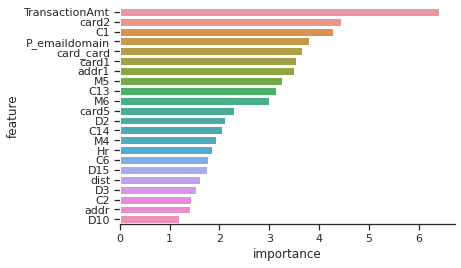

In [ ]:
sns.barplot(x='importance', y='feature', data=feature_imp.head(22))


In [ ]:
+ z.get_height() / 2. +z.get_width()/2

In [ ]:
'top', 'bottom', 'center', 'baseline', 'center_baseline'


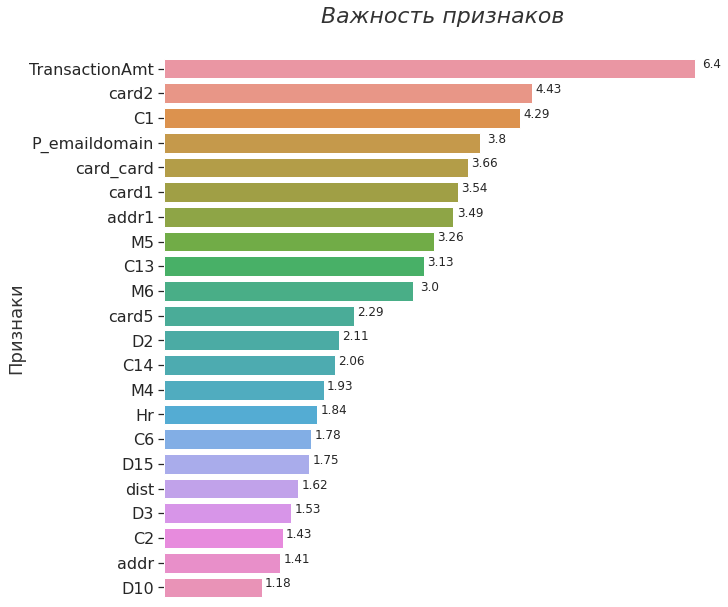

In [ ]:
plt.figure(figsize=(10,10))
annot = {'fontdict' :{'fontsize' :15},'rotation':90}
custom_params = {"axes.spines.right": False, "axes.spines.top": False,
                 "axes.spines.left": False, "axes.spines.bottom": False}
sns.set_theme(style="ticks", rc=custom_params)
ax = sns.barplot(x='importance', y='feature', data=feature_imp.head(22))
for z in ax.patches: 
  ax.annotate('{0:,}'.format(round(z.get_width(),2)) , 
                   (z.get_width()+0.2, z.get_y()+z.get_height()/1.7 ), 
                   ha = 'center', va = 'top', 
                   xytext = (0, 12), 
                   size=12, 
                   textcoords = 'offset points')
plt.ylabel('Признаки', size = 18, color='0.2')
# ax.set_yticklabels([])
plt.yticks(size = 16 )
plt.xticks([]) 
ax.set_xticklabels([])
ax.set_xlabel('')
# plt.xlabel('Важность', size = 18, color='0.2')
# plt.legend(loc='upper right', bbox_to_anchor=(1.05,1), title='Fraud')
plt.title('Важность признаков', size = 22, y=1.05, fontstyle='oblique', color='0.2' );

In [ ]:
len(feature_imp.query('importance==0')['feature'].unique())

29

In [ ]:
feature_imp.query('feature==0')

,feature,importance


## Исследование корреляций

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/feature_import_01_02.csv'
feature_imortans_second = pd.read_csv(path_to_data)
feature_imortans_second.head()

,feature,importance
0,card1,6.793614
1,TransactionAmt,4.716888
2,addr1,4.192885
3,C13,3.768942
4,card2,3.475234


In [ ]:
feature_imortans_second

,feature,importance
0,card1,6.793614
1,TransactionAmt,4.716888
2,addr1,4.192885
3,C13,3.768942
4,card2,3.475234
...,...,...
419,V329,0.000000
420,V330,0.000000
421,V333,0.000000
422,V335,0.000000


In [ ]:

feature_imortans_second.query('feature in ("D8", "D9", "D13", "D14")')

,feature,importance
32,D8,0.726352
47,D13,0.403024
102,D14,0.158346
163,D9,0.056784


In [ ]:
feature_imortans_second.query('feature in ("D5", "D6", "D7", "D12")')

,feature,importance
26,D5,1.239354
75,D12,0.234463
130,D6,0.102225
138,D7,0.085670


In [ ]:
feature_imortans_second.query('feature in ("D1", "D2", "D3", "D4")')

,feature,importance
5,D2,2.996605
14,D1,1.842431
17,D4,1.504991
23,D3,1.397952


Итак: Удаляем D6, D7, D12, D14, D13

In [ ]:
data_train_full["Hr"] = data_train_full["TransactionDT"]/(60*60)%24//1/24

In [ ]:
data_train_full[~data_train_full['D9'].isna()]

,TransactionID,TransactionDT,card1,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,Hr
10,2987010,86549,16496,1.0,1.0,0.0,0.0,0.0,0.0,0.0,83.000000,0.000000,0.0,NaN,0.0,0.0,0.0,0.000000
16,2987016,86620,1790,0.0,NaN,NaN,NaN,NaN,NaN,NaN,26.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
17,2987017,86668,11492,0.0,NaN,NaN,NaN,NaN,NaN,NaN,21.000000,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
38,2987038,87172,5463,542.0,542.0,NaN,NaN,NaN,537.0,4.0,29.000000,0.000000,520.0,NaN,NaN,NaN,NaN,0.000000
40,2987040,87209,13329,0.0,NaN,NaN,0.0,0.0,0.0,0.0,83.000000,0.000000,0.0,NaN,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590501,3577501,15810344,3154,0.0,NaN,0.0,1.0,0.0,1.0,0.0,279.958340,0.958333,0.0,NaN,1.0,0.0,1.0,0.958333
590506,3577506,15810402,16075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,548.958300,0.958333,NaN,NaN,NaN,NaN,NaN,0.958333
590509,3577509,15810491,16136,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.958333,0.958333,0.0,NaN,0.0,0.0,452.0,0.958333
590521,3577521,15810802,12019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.958333,0.958333,0.0,NaN,0.0,0.0,0.0,0.958333


In [ ]:
data_train_full['day']=data_train_full["TransactionDT"]/(60*60)%24//1

In [ ]:
data_train_full[~data_train_full['D1'].isna()]

,TransactionID,TransactionDT,card1,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,Hr,day
0,2987000,86400,13926,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.000000,0.0
1,2987001,86401,2755,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,0.0
2,2987002,86469,4663,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,315.0,NaN,NaN,NaN,0.000000,0.0
3,2987003,86499,18132,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,NaN,NaN,NaN,NaN,0.000000,0.0
4,2987004,86506,4497,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,15811047,6550,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,NaN,NaN,0.958333,23.0
590536,3577536,15811049,10444,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.958333,23.0
590537,3577537,15811079,12037,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.958333,23.0
590538,3577538,15811088,7826,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,22.0,NaN,NaN,NaN,0.958333,23.0


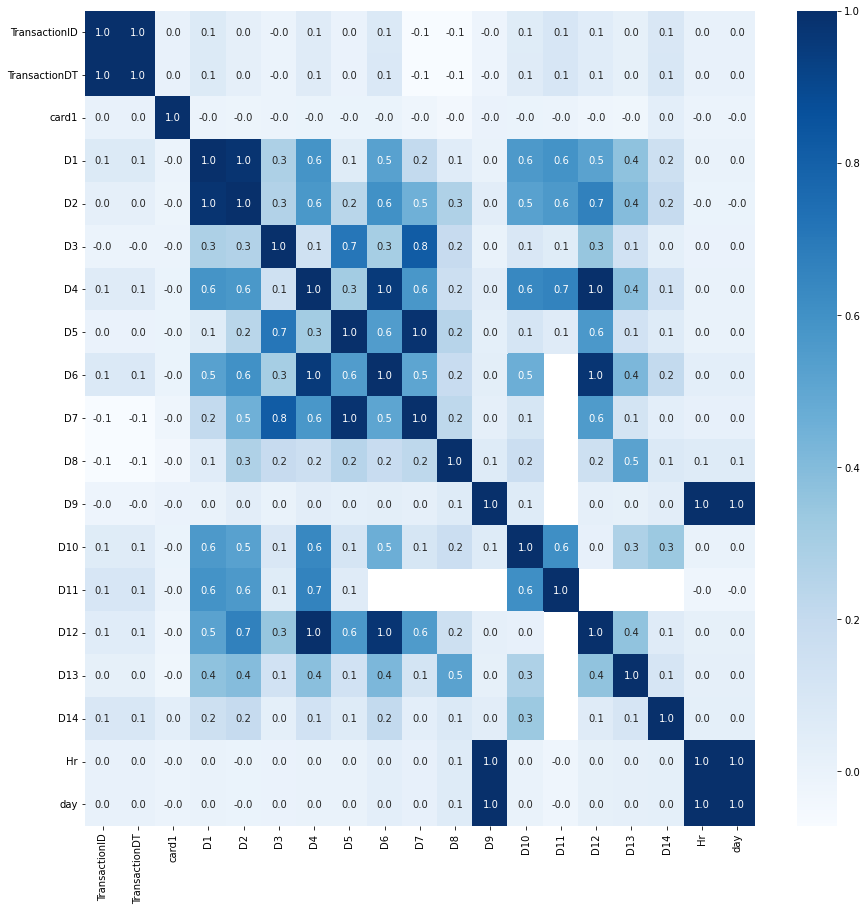

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data_train_full.corr(),cbar=True,cmap='Blues', annot=True, fmt='.1f')

In [ ]:
del data, data_train_full

# Обучение модели

## Подготовка данных


* 1. Убираем список столбцов: 'id_07', 'id_08', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_23',  'id_27' (baseline)
* 2. Убираем столбцы, которые убрали после 2-й попытки - показавшие 0 в feature_importance и также имеющие высокие коэффициенты корреляции
* 3. Добавляем 3 столбца: сгруппированная карта, сгруппированный адрес, сгруппированный dist.
* 4. Убираем столбцец D9 - столбец со временем операции
* 5. Добавляем столбец с часами операции, вычисленными из TransactionDT, а также добавим день, вычисленный из TransactionDT
*   6.Удаляем TransactionDT
* 7. Удалили больше фич V оставили 274 фичи




In [ ]:
# ipython --cache-size=5

In [ ]:
 %reset Out

In [ ]:
path_to_data ='/content/drive/MyDrive/Classroom/F_out_04_02.csv'
feature_out= pd.read_csv(path_to_data)

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/list_off_02_02.csv'
list_off= pd.read_csv(path_to_data)

In [ ]:
feature_out=feature_out.rename(columns = {'0': 'feature'})
list_off=pd.merge(list_off, feature_out, on='feature', how='outer')

In [ ]:
len(list_off)

105

In [ ]:
feat_out= ['id_07', 'id_08', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26',
          'id_23',  'id_27', 'D9', 'V1', 'V9', 'V15', 'V16', 'V18', 'V21',
           'V22', 'V25', 'V27', 'V28', 'V31', 'V34', 'V40', 'V41', 'V42',
           'V46', 'V47', 'V50', 'V52','V57', 'V60', 'V65', 'V68', 'V74', 
           'V84', 'V88', 'V89', 'V92','V94', 'V103', 'V104', 'V111',
           'V112', 'V113', 'V114', 'V116','V117', 'V120', 'V121', 'V123',
           'V125', 'V138', 'V139', 'V140','V142', 'V144', 'V146', 'V147', 
           'V148', 'V152', 'V156', 'V157','V158', 'V161', 'V167', 'V168',
           'V170', 'V174', 'V175', 'V177','V179', 'V180', 'V181', 'V183',
           'V184', 'V185', 'V190', 'V191', 'V192', 'V193', 'V194', 'V197',
           'V199', 'V202', 'V204', 'V209', 'V210', 'V211', 'V213', 'V214',
           'V217', 'V218', 'V219', 'V221', 'V222', 'V223', 'V224', 'V225',
           'V227', 'V228', 'V230', 'V231','V233', 'V235', 'V236', 'V237', 
           'V238', 'V239', 'V240', 'V241','V242', 'V243', 'V244', 'V245',
           'V247', 'V248', 'V249', 'V251','V252', 'V253', 'V255', 'V256',
           'V257', 'V260', 'V261', 'V262','V263', 'V267', 'V269', 'V273',
           'V274', 'V276', 'V277', 'V278','V296', 'V297', 'V298', 'V302',
           'V305', 'V323', 'V324', 'V325','V327', 'V328', 'V329', 'V330',
           'V331', 'V336', 'V338']

In [ ]:
len(feat_out)

149

In [ ]:
addr_feature=['addr1', 'addr2']
card_feature=['card1', 'card2','card3', 'card4', 'card5', 'card6']
identity_feature= ['id_12','id_13', 'id_14', 'id_15', 'id_16', 'id_17',
                  'id_18', 'id_19', 'id_20', 'id_21', 'id_22',               
                  'id_23', 'id_27', 'id_28', 'id_29', 
                  'id_30', 'id_31', 'id_33', 'id_34',
                  'id_35', 'id_36', 'id_37', 'id_38']

In [ ]:
feature_m=['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [ ]:
features_cat_itog=['ProductCD', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo']
features_cat_itog=features_cat_itog+addr_feature+card_feature+identity_feature+feature_m

In [ ]:
numeric_features_itog=['TransactionID', 'TransactionDT', 'TransactionAmt', 'dist1',
                  'dist2', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9',
                  'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5',
                  'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14',
                  'D15', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9',
                  'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18',
                  'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27',
                  'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36',
                  'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45',
                  'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54',
                  'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63',
                  'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72',
                  'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81',
                  'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90',
                  'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99',
                  'V100', 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107',
                  'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115',
                  'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123',
                  'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131',
                  'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139',
                  'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147',
                  'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155',
                  'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163',
                  'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171',
                  'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179',
                  'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187',
                  'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195',
                  'V196', 'V197', 'V198', 'V199', 'V200', 'V201', 'V202', 'V203',
                  'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211',
                  'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219',
                  'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227',
                  'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235',
                  'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243',
                  'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251',
                  'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259',
                  'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267',
                  'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275',
                  'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283',
                  'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291',
                  'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299',
                  'V300', 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307',
                  'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315',
                  'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323',
                  'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331',
                  'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339']

In [ ]:
feature_cat_for_cat=features_cat_itog.copy()
feature_cat_for_cat.extend(['card_card', 'dist', 'addr'])

In [ ]:
feature_cat_for_cat

['ProductCD',
 'P_emaildomain',
 'R_emaildomain',
 'DeviceType',
 'DeviceInfo',
 'addr1',
 'addr2',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_21',
 'id_22',
 'id_23',
 'id_27',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'card_card',
 'dist',
 'addr']

In [ ]:
# columns to convert to integer
column_to_int=['addr1', 'addr2', 'card2', 'card3', 'id_13','card5', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20']

In [ ]:
feature_to_use=numeric_features_itog+features_cat_itog
print(len(feature_to_use))
for col in list_off:
  if col in feature_to_use:
    feature_to_use.remove(col)
  if col in numeric_features_itog:
    numeric_features_itog.remove(col)
  if col in features_cat_itog:
    features_cat_itog.remove(col)  
  if col in feature_cat_for_cat:
    feature_cat_for_cat.remove(col)
for col in feat_out:
  if col in column_to_int:
    column_to_int.remove(col)
  if col in feature_to_use:
    feature_to_use.remove(col)
  if col in numeric_features_itog:
    numeric_features_itog.remove(col)
  if col in features_cat_itog:
    features_cat_itog.remove(col)  
  if col in column_to_int:
    column_to_int.remove(col)
  if col in feature_cat_for_cat:
    feature_cat_for_cat.remove(col)   
print(len(feature_to_use))          

418
274


In [ ]:
feature_to_use

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'dist1',
 'dist2',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V17',
 'V19',
 'V20',
 'V23',
 'V24',
 'V26',
 'V29',
 'V30',
 'V32',
 'V33',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V43',
 'V44',
 'V45',
 'V48',
 'V49',
 'V51',
 'V53',
 'V54',
 'V55',
 'V56',
 'V58',
 'V59',
 'V61',
 'V62',
 'V63',
 'V64',
 'V66',
 'V67',
 'V69',
 'V70',
 'V71',
 'V72',
 'V73',
 'V75',
 'V76',
 'V77',
 'V78',
 'V79',
 'V80',
 'V81',
 'V82',
 'V83',
 'V85',
 'V86',
 'V87',
 'V90',
 'V91',
 'V93',
 'V95',
 'V96',
 'V97',
 'V98',
 'V99',
 'V100',
 'V101',
 'V102',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V110',
 'V115',
 'V118',
 'V119',
 'V122',
 'V124',
 'V126',
 'V127',
 'V128',
 'V129',
 'V

In [ ]:
feature_cat_for_cat

['ProductCD',
 'P_emaildomain',
 'R_emaildomain',
 'DeviceType',
 'DeviceInfo',
 'addr1',
 'addr2',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'id_12',
 'id_13',
 'id_14',
 'id_15',
 'id_16',
 'id_17',
 'id_18',
 'id_19',
 'id_20',
 'id_28',
 'id_29',
 'id_30',
 'id_31',
 'id_33',
 'id_34',
 'id_35',
 'id_36',
 'id_37',
 'id_38',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'card_card',
 'dist',
 'addr']

In [ ]:
# create some new feature
def add_feature(data):
  #groupe card data in one
  data['card_card']=data['card1'].astype(str)+\
                             data['card2'].astype(str) +\
                             data['card3'].astype(str)+\
                             data['card4']+data['card6']+\
                             data['card5'].astype(str)
  # group dist in one
  data['dist']=data['dist1'].astype(str)+data['dist2'].astype(str) 
  # group address in one
  data['addr']=data['addr1'].astype(str)+data['addr2'].astype(str) 
  #create  hour column
  data["Hr"] = data["TransactionDT"]/(60*60)%24//1/24
  #create  day column
  data['day']=data["TransactionDT"]/(60*60)%24//1
  data.drop(columns='TransactionDT', inplace=True)
  # data['Std']=data.groupby('card1')['TransactionAmt'].transform(lambda x: (x - x.mean()))
  return data                            

In [ ]:
# clean some categorical columns
def clean_columns(data):
  for col in column_to_int:
    if data[col].dtype==np.float:
      data[col]=data[col].apply(lambda x: '{0:.0f}'.format(x))
  for col in feature_cat_for_cat:
    data[col].fillna(' ', inplace=True)
    data[col].replace('nan', ' ', inplace=True)
  return data  
  

In [ ]:
f=numeric_features_itog
f.remove('TransactionDT')

In [ ]:
#downcast some numeric columns
def downcasting_num_columns(data):
  
  for col in f:
    if data[col].dtype==float:
      # downcasting a float column
      data[col] = pd.to_numeric(data[col], downcast='float')
    elif  data[col].dtype==int: 
      # downcasting an integer column
      data[col] = pd.to_numeric(data[col], downcast='unsigned')
  return data   

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_train_full_isFraud_03_02_reduced.csv'
X = pd.read_csv(path_to_data,  usecols=feature_to_use)
X.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,...,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V326,V332,V333,V334,V335,V337,V339,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,...,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,New,NotFound,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [ ]:
X=add_feature(X)

In [ ]:
X=clean_columns(X)

In [ ]:
X[column_to_int]

In [ ]:
X[feature_m]

In [ ]:
gc.collect()

242

In [ ]:
X=downcasting_num_columns(X)

In [ ]:
sys.getsizeof(X) / 1024 ** 2

1990.8188076019287

In [ ]:
X

,TransactionID,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,...,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_card,dist,addr,Hr,day
0,2987000,68.500000,W,13926,,150,discover,142,credit,315,87,19.0,NaN,,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,13926nan150.0discovercredit142.0,19.0nan,315.087.0,0.000000,0.0
1,2987001,29.000000,W,2755,404,150,mastercard,102,credit,325,87,NaN,NaN,gmail.com,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,2755404.0150.0mastercardcredit102.0,nannan,325.087.0,0.000000,0.0
2,2987002,59.000000,W,4663,490,150,visa,166,debit,330,87,287.0,NaN,outlook.com,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,315.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,4663490.0150.0visadebit166.0,287.0nan,330.087.0,0.000000,0.0
3,2987003,50.000000,W,18132,567,150,mastercard,117,debit,476,87,NaN,NaN,yahoo.com,,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,84.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,18132567.0150.0mastercarddebit117.0,nannan,476.087.0,0.000000,0.0
4,2987004,50.000000,H,4497,514,150,mastercard,102,credit,420,87,NaN,NaN,gmail.com,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NotFound,,-480,New,NotFound,166,,542,144,New,NotFound,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M,4497514.0150.0mastercardcredit102.0,nannan,420.087.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,49.000000,W,6550,,150,visa,226,debit,272,87,48.0,NaN,,,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,56.0,56.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,6550nan150.0visadebit226.0,48.0nan,272.087.0,0.958333,23.0
590536,3577536,39.500000,W,10444,225,150,mastercard,224,debit,204,87,NaN,NaN,gmail.com,,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,10444225.0150.0mastercarddebit224.0,nannan,204.087.0,0.958333,23.0
590537,3577537,30.950001,W,12037,595,150,mastercard,224,debit,231,87,NaN,NaN,gmail.com,,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,12037595.0150.0mastercarddebit224.0,nannan,231.087.0,0.958333,23.0
590538,3577538,117.000000,W,7826,481,150,mastercard,224,debit,387,87,3.0,NaN,aol.com,,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,22.0,22.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,7826481.0150.0mastercarddebit224.0,3.0nan,387.087.0,0.958333,23.0


In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_train_full_isFraud_03_02_reduced.csv'
y = pd.read_csv(path_to_data,  usecols=['isFraud'])
y.head()

,isFraud
0,0
1,0
2,0
3,0
4,0


In [ ]:
X_train, X_validate, y_train, y_validate = train_test_split(X, y,
                                              test_size=0.25, random_state=42)

In [ ]:
del X
gc.collect()

88

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/data_test_isFraud_03_02_reduced.csv'
X_test = pd.read_csv(path_to_data,  usecols=feature_to_use)
X_test.head()

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,...,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V326,V332,V333,V334,V335,V337,V339,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3663549,18403224,31.95,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,418.0,203.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.00,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,231.0,634.0,...,0.00,77.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.00,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,136.0,136.0,...,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.95,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,242.0,242.0,...,0.00,0.00,282.54,282.54,282.54,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.95,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,22.0,22.0,...,67.95,67.95,67.95,183.85,67.95,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X_test=add_feature(X_test)

In [ ]:
X_test=clean_columns(X_test)

In [ ]:
X_test[column_to_int]

,addr1,addr2,card2,card3,id_13,card5,id_14,id_17,id_18,id_19,id_20
0,170,87,111,150,,226,,,,,
1,299,87,111,150,,226,,,,,
2,472,87,574,150,,226,,,,,
3,205,87,360,150,,166,,,,,
4,264,87,452,150,,117,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
506686,284,60,375,185,,224,,,,,
506687,,,408,185,27,224,,225,15,176,507
506688,327,87,490,150,,226,,,,,
506689,177,87,516,150,,224,,,,,


In [ ]:
X_test[feature_m]

,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,T,T,F,,,F,T,T,T
1,T,F,F,M0,,F,,,
2,T,T,F,M0,F,F,F,F,F
3,T,T,T,,,T,,,
4,T,T,T,,,F,F,T,T
...,...,...,...,...,...,...,...,...,...
506686,,,,M2,,,,,
506687,,,,M2,,,,,
506688,T,T,T,M0,F,F,F,T,T
506689,T,T,T,M0,F,F,F,F,F


In [ ]:
gc.collect()

53

In [ ]:
sys.getsizeof(X_test) / 1024 ** 2

2157.698925971985

In [ ]:
X_test=downcasting_num_columns(X_test)

In [ ]:
sys.getsizeof(X_test) / 1024 ** 2

1709.272442817688

In [ ]:
gc.collect()

52

In [ ]:
ID=X_test['TransactionID']
ID.to_csv('/content/drive/MyDrive/Classroom/ID_05_02.csv', index=False)

Сохраняем данные

In [ ]:
X_train.to_csv('/content/drive/MyDrive/Classroom/X_train_06_02_try6_4.csv', index=False)

In [ ]:
X_validate.to_csv('/content/drive/MyDrive/Classroom/X_validate_06_02_try6_4.csv', index=False)

In [ ]:
X_test.to_csv('/content/drive/MyDrive/Classroom/X_test_06_02_try6_4.csv', index=False)

In [ ]:
y_train.to_csv('/content/drive/MyDrive/Classroom/y_train_06_02_try65_4.csv', index=False)

In [ ]:
y_validate.to_csv('/content/drive/MyDrive/Classroom/y_validatet_06_02_try6_4.csv', index=False)

In [ ]:
del X_train, X_validate, X_test
del y_train, y_validate
gc.collect()

## Модель и ее обучение

In [ ]:
feature_cat_for_cat=['ProductCD', 'P_emaildomain',
 'R_emaildomain', 'DeviceType', 'DeviceInfo',
 'addr1', 'addr2', 'card1', 'card2', 'card3',
 'card4', 'card5', 'card6', 'id_12', 'id_13',
 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
 'id_19', 'id_20', 'id_28', 'id_29', 'id_30',
 'id_31', 'id_33', 'id_34', 'id_35', 'id_36',
 'id_37', 'id_38', 'M1', 'M2', 'M3', 'M4',
 'M5', 'M6', 'M7', 'M8', 'M9', 'card_card',
 'dist', 'addr']

In [ ]:
# 'ProductCD', 'P_emaildomain', 'R_emaildomain',
#  'DeviceType', 'DeviceInfo', 'addr1', 'addr2',
#  'card1', 'card2', 'card3', 'card4', 'card5',
#  'card6', 'id_12', 'id_13', 'id_14', 'id_15',
#  'id_16', 'id_17', 'id_18','id_19', 'id_20',
#  'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
#  'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
#  'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7',
#  'M8', 'M9', 'card_card', 'dist', 'addr'

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/X_train_06_02_try6_4.csv'
X_train = pd.read_csv(path_to_data,  index_col='TransactionID')
X_train.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,...,V316,V317,V318,V319,V320,V321,V322,V326,V332,V333,V334,V335,V337,V339,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_card,dist,addr,Hr,day
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3126425,87.0,W,10847,302,150,visa,226,credit,325,87,NaN,NaN,anonymous.com,,139.0,118.0,0.0,0.0,86.0,93.0,0.0,0.0,82.0,0.0,99.0,0.0,410.0,112.0,512.0,512.0,1.0,512.0,1.0,NaN,NaN,NaN,512.0,NaN,NaN,NaN,...,0.0,2577.0,157.0,0.0,736.0,736.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,10847302.0150.0visacredit226.0,nannan,325.087.0,0.916667,22.0
3138318,500.0,R,15446,460,150,mastercard,224,debit,226,87,NaN,NaN,aol.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NotFound,52,-360,New,NotFound,166,,529,299,New,NotFound,Windows 7,ie 11.0 for desktop,1600x900,match_status:2,T,F,T,T,desktop,Trident/7.0,15446460.0150.0mastercarddebit224.0,nannan,226.087.0,0.000000,0.0
3280546,117.0,W,11127,567,150,mastercard,219,debit,204,87,NaN,NaN,aol.com,,1.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,2.0,0.0,13.0,1.0,423.0,423.0,0.0,423.0,3.0,NaN,NaN,NaN,17.0,NaN,NaN,NaN,...,117.0,234.0,234.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,11127567.0150.0mastercarddebit219.0,nannan,204.087.0,0.875000,21.0
3442167,117.0,W,7919,194,150,mastercard,166,debit,126,87,NaN,NaN,,,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,22.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,482.0,0.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,7919194.0150.0mastercarddebit166.0,nannan,126.087.0,0.750000,18.0
3479621,49.0,W,2485,555,150,visa,226,debit,251,87,15.0,NaN,,,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,19.0,2.0,159.0,159.0,12.0,NaN,NaN,NaN,NaN,NaN,272.0,275.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,2485555.0150.0visadebit226.0,15.0nan,251.087.0,0.791667,19.0


In [ ]:
%time
path_to_data = '/content/drive/MyDrive/Classroom/X_validate_06_02_try6_4.csv'
X_validate = pd.read_csv(path_to_data,  index_col='TransactionID')
X_validate.head()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 8.34 µs


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,...,V316,V317,V318,V319,V320,V321,V322,V326,V332,V333,V334,V335,V337,V339,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_card,dist,addr,Hr,day
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3457624,724.000,W,7826,481,150,mastercard,224,debit,387,87,NaN,NaN,aol.com,,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,2.0,0.0,NaN,NaN,145.0,0.0,NaN,NaN,NaN,145.0,0.0,NaN,NaN,...,0.0000,0.0000,0.0000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,7826481.0150.0mastercarddebit224.0,nannan,387.087.0,0.625000,15.0
3552820,108.500,W,12544,321,150,visa,226,debit,476,87,0.0,NaN,yahoo.com,,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,7.0,2.0,122.0,122.0,5.0,347.0,5.0,NaN,NaN,NaN,347.0,122.0,NaN,NaN,...,0.0000,0.0000,0.0000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,12544321.0150.0visadebit226.0,0.0nan,476.087.0,0.666667,16.0
3271083,47.950,W,9400,111,150,mastercard,224,debit,315,87,6.0,NaN,gmail.com,,1.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,1.0,32.0,32.0,22.0,22.0,22.0,NaN,NaN,NaN,33.0,33.0,NaN,NaN,...,0.0000,0.0000,0.0000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,9400111.0150.0mastercarddebit224.0,6.0nan,315.087.0,0.666667,16.0
3226689,100.599,C,15885,545,185,visa,138,debit,,,NaN,NaN,gmail.com,gmail.com,2.0,3.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN,...,100.5993,100.5993,100.5993,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,15885545.0185.0visadebit138.0,nannan,nannan,0.666667,16.0
3268855,107.950,W,15497,490,150,visa,226,debit,299,87,NaN,NaN,hotmail.com,,10.0,14.0,0.0,0.0,11.0,8.0,0.0,0.0,6.0,0.0,10.0,0.0,43.0,9.0,549.0,549.0,16.0,549.0,16.0,NaN,NaN,NaN,446.0,NaN,NaN,NaN,...,0.0000,0.0000,0.0000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,15497490.0150.0visadebit226.0,nannan,299.087.0,0.666667,16.0


In [ ]:
%time
path_to_data = '/content/drive/MyDrive/Classroom/X_test_06_02_try6_4.csv'
X_test = pd.read_csv(path_to_data,  index_col='TransactionID')
X_test.head()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D10,D11,D12,D13,...,V316,V317,V318,V319,V320,V321,V322,V326,V332,V333,V334,V335,V337,V339,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,card_card,dist,addr,Hr,day
TransactionID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3663549,31.95,W,10409,111,150,visa,226,debit,170,87,1.0,NaN,gmail.com,,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,418.0,203.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,10409111.0150.0visadebit226.0,1.0nan,170.087.0,0.0,0.0
3663550,49.00,W,4272,111,150,visa,226,debit,299,87,4.0,NaN,aol.com,,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,231.0,634.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,4272111.0150.0visadebit226.0,4.0nan,299.087.0,0.0,0.0
3663551,171.00,W,4476,574,150,visa,226,debit,472,87,2635.0,NaN,hotmail.com,,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,136.0,136.0,NaN,NaN,...,0.0,0.0,0.0,0.0,263.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,4476574.0150.0visadebit226.0,2635.0nan,472.087.0,0.0,0.0
3663552,284.95,W,10989,360,150,visa,166,debit,205,87,17.0,NaN,gmail.com,,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,242.0,242.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,10989360.0150.0visadebit166.0,17.0nan,205.087.0,0.0,0.0
3663553,67.95,W,18018,452,150,mastercard,117,debit,264,87,6.0,NaN,gmail.com,,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,22.0,22.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,,,,,,,,,,,,,,,,,,,,,,18018452.0150.0mastercarddebit117.0,6.0nan,264.087.0,0.0,0.0


In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/y_train_06_02_try65_4.csv'
y_train = pd.read_csv(path_to_data)
y_train.head()

,isFraud
0,0
1,0
2,0
3,0
4,0


In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/y_validatet_06_02_try6_4.csv'
y_validate = pd.read_csv(path_to_data)
y_validate.head()

,isFraud
0,0
1,0
2,0
3,0
4,0


In [ ]:
gc.collect()

292

In [ ]:
sys.getsizeof(X_train) / 1024 ** 2

2358.0613832473755

In [ ]:
sys.getsizeof(X_test) / 1024 ** 2

2683.862072944641

In [ ]:
sys.getsizeof(X_validate) / 1024 ** 2

786.0538263320923

In [ ]:
path_to_data = '/content/drive/MyDrive/Classroom/ID_05_02.csv'
ID = pd.read_csv(path_to_data)
ID.head()

,TransactionID
0,3663549
1,3663550
2,3663551
3,3663552
4,3663553


In [ ]:
gc.collect()

193

In [ ]:
ID

### CatBoost

In [ ]:
!pip install -q catboost shap

     |████████████████████████████████| 76.1 MB 1.2 MB/s 
     |████████████████████████████████| 564 kB 48.4 MB/s 


In [ ]:
import catboost
from catboost import CatBoostClassifier

import shap
import sklearn.model_selection
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
gc.collect()

59

In [ ]:
train_pool = catboost.Pool(
    X_train,
    label=y_train,
    cat_features=feature_cat_for_cat
)
val_pool = catboost.Pool(
    X_validate,
    label=y_validate,
    cat_features=feature_cat_for_cat
)
test_pool = catboost.Pool(
    X_test,
    cat_features=feature_cat_for_cat
)

In [ ]:
!rm -rf 'catboost_clf_find_fraud/snapshot.bkp'

In [ ]:
catboost_train_dir = 'catboost_clf_find_fraud'
clf = catboost.CatBoostClassifier(
    loss_function='Logloss',
    custom_loss='AUC',
    logging_level='Silent',
    eval_metric='AUC',
    od_pval=0.05,
    od_wait=20,
    # early_stopping_rounds=20,
    # random_seed=52,
    train_dir=catboost_train_dir,
    # task_type='CPU',
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    use_best_model=True
)
clf.fit(
    train_pool, 
    eval_set=val_pool,
    plot=True,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
clf.best_score_

{'learn': {'AUC': 0.9713953137397766, 'Logloss': 0.22890973982759938},
 'validation': {'AUC': 0.9705962538719177, 'Logloss': 0.2210932328684965}}

In [ ]:
clf.best_iteration_

999

In [ ]:
gc.collect()

584

### Сохранение модели в файл
model.save_model('catboost 5.08.22')
### Загрузка модели из файла
from_file = cb.CatBoostClassifier()
from_file.load_model('catboost 5.08.22')

In [ ]:
clf.save_model('catboost 6.08.22')

In [ ]:
clf = catboost.CatBoostClassifier()
clf.load_model('catboost 6.08.22')

Предсказываем

In [ ]:
vt_pool = catboost.Pool(
    X_validate,
    cat_features=feature_cat_for_cat
    )  

tt_pool = catboost.Pool(
    X_train,
    cat_features=feature_cat_for_cat
) 
y_pred_train = clf.predict(tt_pool)
y_pred_val = clf.predict(vt_pool)
y_pred_submit = clf.predict(test_pool)


In [ ]:
y_pred_proba_submit = clf.predict_proba(test_pool)

In [ ]:
gc.collect()

88

Сохраняем результат

In [ ]:
len(y_pred_submit)

506691

In [ ]:
ID

,TransactionID
0,3663549
1,3663550
2,3663551
3,3663552
4,3663553
...,...
506686,4170235
506687,4170236
506688,4170237
506689,4170238


In [ ]:
y_pred_submit.sum()/X_test.shape[0]

0.09122917123059221

In [ ]:
res=pd.Series(y_pred_submit)

In [ ]:
res

0         0
1         0
2         0
3         0
4         0
         ..
506686    0
506687    0
506688    0
506689    0
506690    0
Length: 506691, dtype: int64

In [ ]:
y_pred_submit_res=pd.DataFrame(res, columns=['isFraud'])

In [ ]:
y_pred_submit_res=pd.concat([ID, y_pred_submit_res], axis=1)

In [ ]:
y_pred_submit_res

,TransactionID,isFraud
0,3663549,0
1,3663550,0
2,3663551,0
3,3663552,0
4,3663553,0
...,...,...
506686,4170235,0
506687,4170236,0
506688,4170237,0
506689,4170238,0


In [ ]:
y_pred_submit_res.to_csv('/content/drive/MyDrive/Classroom/submit_isFraud_06_02_try6_4.csv', index=False)

In [ ]:
y.sum()/y.shape[0]

isFraud    0.03499
dtype: float64

In [ ]:
y_pred_submit_res.isFraud.sum()/y_pred_submit_res.shape[0]

0.09122917123059221

In [ ]:
proba=pd.DataFrame(y_pred_proba_submit)

In [ ]:
proba

,0,1
0,0.979801,0.020199
1,0.813978,0.186022
2,0.994002,0.005998
3,0.956343,0.043657
4,0.929936,0.070064
...,...,...
506686,0.729123,0.270877
506687,0.909539,0.090461
506688,0.864358,0.135642
506689,0.783868,0.216132


In [ ]:
proba[1]

0         0.008725
1         0.019236
2         0.000476
3         0.007880
4         0.036358
            ...   
506686    0.214238
506687    0.032585
506688    0.085328
506689    0.112674
506690    0.062610
Name: 1, Length: 506691, dtype: float64

In [ ]:
submission = pd.DataFrame(columns=['TransactionID'], data= ID)
submission['isFraud'] = proba[1]
submission.head()
# submission.isFraud.value_counts()

,TransactionID,isFraud
0,3663549,0.020199
1,3663550,0.186022
2,3663551,0.005998
3,3663552,0.043657
4,3663553,0.070064


In [ ]:
submission.isFraud.value_counts()

0.851243    10
0.050623     6
0.990885     6
0.008221     6
0.999338     5
            ..
0.070424     1
0.045712     1
0.080231     1
0.044641     1
0.100462     1
Name: isFraud, Length: 506234, dtype: int64

In [ ]:
submission.to_csv('/content/drive/MyDrive/Classroom/submit_isFraud_06_02_try6_3_proba.csv', index=False)

###Анализируем результат

In [ ]:
gc.collect()

248

График обучения

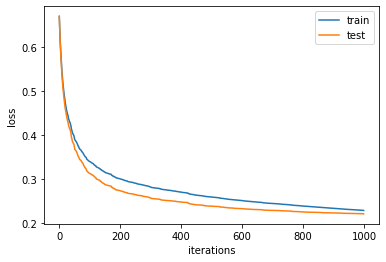

In [ ]:
hist = clf.get_evals_result()
plt.plot(list(hist['learn'].values())[0], label= 'train')
plt.plot(list(hist['validation'].values())[0], label = 'test')
plt.ylabel('loss')
plt.xlabel('iterations')
plt.legend()
plt.show()

In [ ]:
feature_import=sorted(
    zip(X_train.columns, clf.feature_importances_), 
    key=lambda p: p[1], 
    reverse=True
)

Сохраняем feature_import

In [ ]:
feature_import

[('C1', 7.166967262442168),
 ('card1', 5.831428207868163),
 ('C14', 4.442678219332582),
 ('TransactionAmt', 4.1660810209057715),
 ('card_card', 4.136573641639178),
 ('P_emaildomain', 3.4717807896868162),
 ('C13', 3.2986595854192884),
 ('dist', 3.1096590442697467),
 ('addr1', 2.923077096699045),
 ('card2', 2.4531535191085427),
 ('M5', 2.3380819150415966),
 ('DeviceInfo', 1.9553414016263935),
 ('D2', 1.8926735251967406),
 ('C6', 1.721515924037286),
 ('R_emaildomain', 1.6315421200134836),
 ('V258', 1.5917519469046566),
 ('D15', 1.5476790262444797),
 ('id_19', 1.4432230705044995),
 ('C11', 1.3649188240884342),
 ('M6', 1.2753333694241642),
 ('dist1', 1.16558654004413),
 ('card5', 1.1525819754318276),
 ('M4', 1.1283230012658736),
 ('ProductCD', 1.097265919001573),
 ('C5', 1.0398904025456943),
 ('addr', 1.014200826827139),
 ('V308', 1.005352143479031),
 ('D4', 0.9647404568377648),
 ('C2', 0.9409218095674778),
 ('V317', 0.9346729751294952),
 ('id_31', 0.9256376561903829),
 ('id_20', 0.91355691

In [ ]:
feature_import=pd.DataFrame(feature_import, columns=['feature', 'importance'])

In [ ]:
feature_import.to_csv('/content/drive/MyDrive/Classroom/feature_import_06_02_v6_4.csv', index=False)

In [ ]:
del X_test
gc.collect()

2830

In [ ]:
gc.collect()

88

In [ ]:
shap_info = clf.get_feature_importance(
    data=train_pool, 
    type='ShapValues', 
    verbose=10000
)
shap_values = shap_info[:,:-1]
base_values = shap_info[:,-1]

Processing trees...
128/1000 trees processed	passed time: 485ms	remaining time: 3.3s
1000/1000 trees processed	passed time: 2.69s	remaining time: 0us
Processing documents...
128/442905 documents processed	passed time: 29.1ms	remaining time: 1m 40s
10112/442905 documents processed	passed time: 1.94s	remaining time: 1m 23s
20096/442905 documents processed	passed time: 3.85s	remaining time: 1m 21s
30080/442905 documents processed	passed time: 5.83s	remaining time: 1m 19s
40064/442905 documents processed	passed time: 7.79s	remaining time: 1m 18s
50048/442905 documents processed	passed time: 9.77s	remaining time: 1m 16s
60032/442905 documents processed	passed time: 11.7s	remaining time: 1m 14s
70016/442905 documents processed	passed time: 13.5s	remaining time: 1m 11s
80128/442905 documents processed	passed time: 15.4s	remaining time: 1m 9s
90112/442905 documents processed	passed time: 17.3s	remaining time: 1m 7s
100096/442905 documents processed	passed time: 19.2s	remaining time: 1m 5s
1100

In [ ]:
/content/catboost_clf_find_fraud/snapshot.bkp

In [ ]:
shap.summary_plot(shap_values, X_train)

### Результат в Kaggle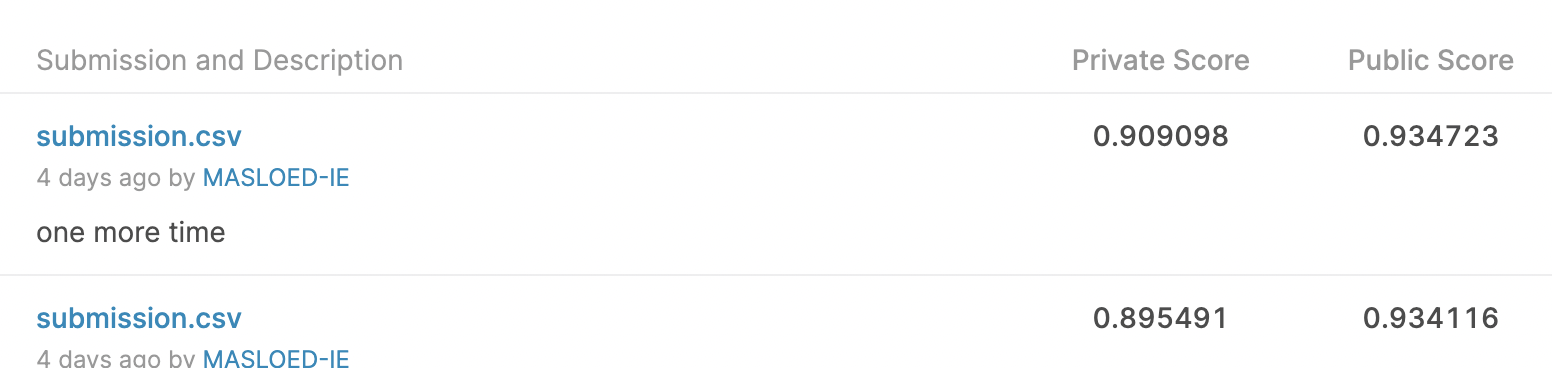

## Уменьшение размерности методом PCA

In [ ]:
#!pip install kaggle
from google.colab import files
from google.colab import drive
from zipfile import ZipFile
from google.colab import files

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc

drive.mount('/content/gdrive')
pd.options.display.float_format = "{:,.2f}".format


def update_kaggle_token():
  uploaded = files.upload()

  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
  
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

update_kaggle_token()

%cd /
%cd /content
!mkdir -p kaggle/GP2/
%cd kaggle/GP2
!kaggle competitions download -c ieee-fraud-detection
%cd /content


Mounted at /content/gdrive


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes
/
/content
/content/kaggle/GP2
 89% 52.0M/58.3M [00:00<00:00, 111MB/s] 
100% 58.3M/58.3M [00:00<00:00, 168MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 107MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 107MB/s]
 61% 32.0M/52.2M [00:00<00:00, 100MB/s] 
100% 52.2M/52.2M [00:00<00:00, 174MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 159MB/s]
/content


### Загружаем  Train датасет

In [ ]:
path = "kaggle/GP2/"
file_train_transactions = "train_transaction.csv"
file_test_transactions = "test_transaction.csv"
file_train_identity = "train_identity.csv"
file_test_identity = "test_identity.csv"

def get_zip_file(path, file_name):
  return path + file_name + ".zip"

def get_big_data_from_zip(path, file_name):
  file = ZipFile(get_zip_file(path, file_name)).open(file_name)
  tp = pd.read_csv(file, iterator=True, chunksize=50_000)
  #tp = pd.read_csv(file, iterator=True, chunksize=10_000, nrows=200_000)

  return pd.concat(tp)

%time raw_train_transactions = get_big_data_from_zip(path, file_train_transactions)

#%time raw_test_transactions = get_big_data_from_zip(path, file_test_transactions)

%time raw_train_identity = get_big_data_from_zip(path, file_train_identity)

#%time raw_test_identity = get_big_data_from_zip(path, file_test_identity)

train = pd.merge(raw_train_transactions, raw_train_identity, how = 'left', on = 'TransactionID')

del raw_train_transactions, raw_train_identity
gc.collect

print(train.shape)

CPU times: user 26.8 s, sys: 524 ms, total: 27.3 s
Wall time: 27.3 s
CPU times: user 607 ms, sys: 18 ms, total: 624 ms
Wall time: 619 ms
(590540, 434)


In [ ]:
 # Выведем список колонок так, чтобы из него было удобно собирать массив
 str = '' 
 for c in train.columns:
   str += f"'{c}', "
 print(str)

'TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V8

In [ ]:
#Разобьем фичи на разные списки для удобства обработки

target = 'isFraud'
COLS_EXCLUDE = ['TransactionID',  'TransactionDT']

c1 =['TransactionID', 'isFraud', 'TransactionDT',
      'DeviceType', 'DeviceInfo',]#exclude


c_object = ['ProductCD']

c_object_with_na = ['card4', 'card6',  'P_emaildomain', 'R_emaildomain', ]

#f
c_int  = ['card1',]

#f
c_float_to_int_with_na = [ 'card2', 'card3', 'card5', 'addr1', 'addr2',  'dist1', 'dist2',  'TransactionAmt']

#non nan, float 
# Упс!! !!!! в тестовом дата сете полно нулей
c_C =[ 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
 
# with nan, float
c_D = [ 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15',] 
 
# with nan, object 
c_M = [ 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', ] 


#with  nan, float
c_V = [ 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V39', 'V40', 'V41', 'V42', 'V43', 'V44', 'V45', 'V46', 'V47', 'V48', 'V49', 'V50', 'V51', 'V52', 'V53', 'V54', 'V55', 'V56', 'V57', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V65', 'V66', 'V67', 'V68', 'V69', 'V70', 'V71', 'V72', 'V73', 'V74', 'V75', 'V76', 'V77', 'V78', 'V79', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V86', 'V87', 'V88', 'V89', 'V90', 'V91', 'V92', 'V93', 'V94', 'V95', 'V96', 'V97', 'V98', 'V99', 'V100', 
 'V101', 'V102', 'V103', 'V104', 'V105', 'V106', 'V107', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113', 'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121', 'V122', 'V123', 'V124', 'V125', 'V126', 'V127', 'V128', 'V129', 'V130', 'V131', 'V132', 'V133', 'V134', 'V135', 'V136', 'V137', 'V138', 'V139', 'V140', 'V141', 'V142', 'V143', 'V144', 'V145', 'V146', 'V147', 'V148', 'V149', 'V150', 'V151', 'V152', 'V153', 'V154', 'V155', 'V156', 'V157', 'V158', 'V159', 'V160', 'V161', 'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V168', 'V169', 'V170', 'V171', 'V172', 'V173', 'V174', 'V175', 'V176', 'V177', 'V178', 'V179', 'V180', 'V181', 'V182', 'V183', 'V184', 'V185', 'V186', 'V187', 'V188', 'V189', 'V190', 'V191', 'V192', 'V193', 'V194', 'V195', 'V196', 'V197', 'V198', 'V199', 
 'V200', 'V201', 'V202', 'V203', 'V204', 'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V211', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V218', 'V219', 'V220', 'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V230', 'V231', 'V232', 'V233', 'V234', 'V235', 'V236', 'V237', 'V238', 'V239', 'V240', 'V241', 'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V248', 'V249', 'V250', 'V251', 'V252', 'V253', 'V254', 'V255', 'V256', 'V257', 'V258', 'V259', 'V260', 'V261', 'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V269', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V287', 'V288', 'V289', 'V290', 'V291', 'V292', 'V293', 'V294', 'V295', 'V296', 'V297', 'V298', 'V299', 'V300', 
 'V301', 'V302', 'V303', 'V304', 'V305', 'V306', 'V307', 'V308', 'V309', 'V310', 'V311', 'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320', 'V321', 'V322', 'V323', 'V324', 'V325', 'V326', 'V327', 'V328', 'V329', 'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338', 'V339', 
] 

#with  nan, float and object ->
c_id =  ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
  'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 
  'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 
  ]


c_id_float =  ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_13', 'id_14', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25', 'id_26', 'id_32', ]
c_id_obj = ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', ]

c_float_and_int = c_int + c_float_to_int_with_na + c_C+ c_D + c_V + c_id_float

c_obj_to_model = c_object + c_object_with_na  + c_id_obj

c_cat = c_C + c_V


In [ ]:
from sklearn.impute import SimpleImputer

# пока простое избавление от пропущенных значений
def prepare_data(data):

  #################### все столбцы C
  print("C_ columns processing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0)
  imputer.fit(data[c_C])
  data[c_C] = imputer.transform(data[c_C])
  data[c_C] = data[c_C].astype(int)


  #################### все столбцы V
  print("V_ columns processing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0)
  imputer.fit(data[c_V])
  data[c_V] = imputer.transform(data[c_V])
  data[c_V] = data[c_V].astype(int)


  #################### все столбцы id_
  col_id_float =[]
  col_id_obj =[]

  print("id_ columns processing...")
  for col in c_id:
    if data[col].dtype == np.object: col_id_obj.append(col)
    elif data[col].dtype == np.float64: col_id_float.append(col)
    else: print(f'error: {col.dtype}')

  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0)
  imputer.fit(data[col_id_float])
  data[col_id_float] = imputer.transform(data[col_id_float])


  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = "NO_INFO")
  imputer.fit(data[col_id_obj])
  data[col_id_obj] = imputer.transform(data[col_id_obj])

   #################### все столбцы D_
  print("D_ columns processing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0)
  imputer.fit(data[c_D])
  data[c_D] = imputer.transform(data[c_D])

   #################### все столбцы M_
  print("M_ columns processing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = "NO_INFO")
  imputer.fit(data[c_M])
  data[c_M] = imputer.transform(data[c_M])

   #################### остальный  object столбцы с na
  print("other object columns processing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = "NO_INFO")
  imputer.fit(data[c_object_with_na])
  data[c_object_with_na] = imputer.transform(data[c_object_with_na])

   #################### остальный  float  столбцы с na. которые можно перевести в инт
  print("other float columns processing...")
  imputer = SimpleImputer(missing_values = np.nan, strategy = 'constant', fill_value = 0)
  imputer.fit(data[c_float_to_int_with_na])
  data[c_float_to_int_with_na] = imputer.transform(data[c_float_to_int_with_na])
  data[c_float_to_int_with_na] = data[c_float_to_int_with_na].astype(int)

  return data

#train = prepare_data(train)


In [ ]:
#Всякие методы, может еще пригодятся
def inf(n):
  print(n)
  print(train[n].describe())
  print(train[n].isna().sum())
  print(train[n].dtype)
  print(train[n].value_counts())

In [ ]:
n = "C1"
inf(n)

In [ ]:
str = ""
for col in train.columns:
  if col.startswith("id_") or col.startswith("C") or  col.startswith("D"): str = str+ "'" + col +  "', "
print(str)

'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06', 'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 


In [ ]:

def get_obj_cols(data, with_na):
  col_obj = []
  for col in data.columns:
      dtype = data[col].dtype
      
      if with_na: 
        isWithNa = data[col].isna().sum() > 0
        if dtype == np.object and isWithNa: col_obj.append(col) 

      else:
        if  dtype == np.object: col_obj.append(col) 
  return col_obj


### Разбиваем данные и готовим

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

target = 'isFraud'
y = train[target]
X = train.drop(target, 1)

#'TransactionID', 'isFraud', 'TransactionDT',
X = train.drop('TransactionID', 1)
X = train.drop('TransactionDT', 1)
X = train.drop('DeviceType', 1)
X = train.drop('DeviceInfo', 1)


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

del X, y,train, 
gc.collect

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWar

<function gc.collect>

In [ ]:
print(X_train.shape)
print(y_train.shape)

(413378, 433)
(413378,)


In [ ]:
X_train  = prepare_data(X_train)
X_val  = prepare_data(X_val)

C_ columns processing...
V_ columns processing...
id_ columns processing...
D_ columns processing...
M_ columns processing...
other object columns processing...
other float columns processing...
C_ columns processing...
V_ columns processing...
id_ columns processing...
D_ columns processing...
M_ columns processing...
other object columns processing...
other float columns processing...


In [ ]:
print(X_train.shape)
print(y_train.shape)

(413378, 433)
(413378,)


### Попытка применения PCA

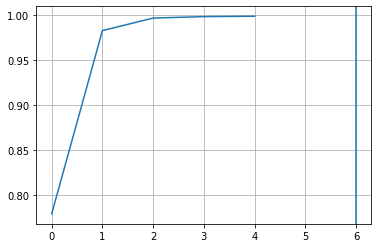

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(5)
pca.fit(X_train[c_float_and_int])
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.axvline(x=6)
plt.grid()

In [ ]:
X_train_pca_part = pd.DataFrame(pca.transform(X_train[c_float_and_int]))
X_val_pca_part = pd.DataFrame(pca.transform(X_val[c_float_and_int]))

In [ ]:
print(X_train_pca_part.isna().sum().sum())


0


In [ ]:
X_train_prepared = X_train_pca_part
#X_train_prepared[c_obj_to_model] =  X_train[c_obj_to_model].values
X_train_prepared[c_cat] =  X_train[c_cat].values
print(X_train_prepared .isna().sum().sum())


X_val_prepared = X_val_pca_part
#X_val_prepared[c_obj_to_model] =  X_val[c_obj_to_model] .values
X_val_prepared[c_cat] =  X_val[c_cat].values


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


0


In [ ]:
print(X_train_prepared.shape)
print(y_train.shape)

(413378, 358)
(413378,)


In [ ]:
X_train_prepared .isna().sum().sum()

0

In [ ]:
X_train_pca_part.shape

(413378, 5)

### Попытка применения Catboost

In [ ]:
!pip install -q catboost shap

     |████████████████████████████████| 76.1 MB 1.8 MB/s 
     |████████████████████████████████| 564 kB 48.4 MB/s 


In [ ]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

model = CatBoostClassifier( task_type="GPU") 
model.fit(
    X_train_prepared, 
    y_train,  
    cat_features = c_cat,
    #text_features = c_obj_to_model
    ) 
y_pred = model.predict(X_val_prepared) 
print(f"{roc_auc_score(y_pred, y_val)}")
 

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

Learning rate set to 0.024203
0:	learn: 0.6514509	total: 608ms	remaining: 10m 7s
1:	learn: 0.6124761	total: 1.54s	remaining: 12m 47s
2:	learn: 0.5773092	total: 2.13s	remaining: 11m 47s
3:	learn: 0.5452572	total: 2.71s	remaining: 11m 14s
4:	learn: 0.5150909	total: 3.28s	remaining: 10m 53s
5:	learn: 0.4860795	total: 4.22s	remaining: 11m 39s
6:	learn: 0.4598052	total: 4.8s	remaining: 11m 21s
7:	learn: 0.4361482	total: 5.55s	remaining: 11m 27s
8:	learn: 0.4133540	total: 6.31s	remaining: 11m 35s
9:	learn: 0.3933616	total: 6.91s	remaining: 11m 24s
10:	learn: 0.3747656	total: 7.84s	remaining: 11m 45s
11:	learn: 0.3577740	total: 8.61s	remaining: 11m 48s
12:	learn: 0.3415253	total: 9.19s	remaining: 11m 37s
13:	learn: 0.3264181	total: 9.77s	remaining: 11m 27s
14:	learn: 0.3119636	total: 10.4s	remaining: 11m 20s
15:	learn: 0.2983461	total: 11s	remaining: 11m 13s
16:	learn: 0.2861036	total: 11.5s	remaining: 11m 7s
17:	learn: 0.2742576	total: 12.2s	remaining: 11m 3s
18:	learn: 0.2634746	total: 12.7

In [ ]:
print(f"{roc_auc_score(y_pred, y_val)}")


0.9472109211900297


### Загружаем  тестовый датасет

In [ ]:
%time raw_test_transactions = get_big_data_from_zip(path, file_test_transactions)
%time raw_test_identity = get_big_data_from_zip(path, file_test_identity)
test = pd.merge(raw_test_transactions, raw_test_identity, how = 'left', on = 'TransactionID')
X = test
del raw_test_transactions, raw_test_identity, test
gc.collect


CPU times: user 23 s, sys: 1.65 s, total: 24.6 s
Wall time: 24.5 s
CPU times: user 595 ms, sys: 29 ms, total: 624 ms
Wall time: 619 ms


<function gc.collect>

In [ ]:
del test
gc.collect()

NameError: ignored

In [ ]:

Y_ID = X['TransactionID']
X = X.drop('TransactionID', 1)
X = X.drop('TransactionDT', 1)
X = X.drop('DeviceType', 1)
X = X.drop('DeviceInfo', 1)

test_c_id = list(map(lambda c: c.replace("_","-"), c_id))
c_dict = dict(zip(test_c_id, c_id))
X = X.rename(columns = c_dict)

X_test  = prepare_data(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


C_ columns processing...
V_ columns processing...
id_ columns processing...
D_ columns processing...
M_ columns processing...
other object columns processing...
other float columns processing...


In [ ]:
X_test_pca_part = pd.DataFrame(pca.transform(X_test[c_float_and_int]))

X_test_prepared = X_test_pca_part
#XX_test_prepared[c_obj_to_model] =  X_val[c_obj_to_model] .values
X_test_prepared[c_cat] =  X_test[c_cat].values

Y_test_pred = model.predict(X_test_prepared)
submission = pd.DataFrame(columns=['TransactionID'], data= Y_ID)
submission[target] = Y_test_pred
submission.head()
submission.isFraud.value_counts()

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


0    498595
1      8096
Name: isFraud, dtype: int64

### 3. Загрузка  тестовых значений

In [ ]:
submission.to_csv("submission.csv", index = False)

In [ ]:
!kaggle competitions submit -c ieee-fraud-detection -f "submission.csv" -m "one more time"

100% 4.83M/4.83M [00:00<00:00, 16.1MB/s]
Successfully submitted to IEEE-CIS Fraud Detection

In [ ]:
del X,X_test_pca_part,X_test
gc.collect()

#Сравнение моделей


Ссылка на ноутбук https://colab.research.google.com/drive/1mgTTfH1AykSkeFREw1FATaScun_PR3E5?usp=sharing

## Загрузка данных

Files
- train_{transaction, identity}.csv - the training set
- test_{transaction, identity}.csv - the test set (you must predict the isFraud value for these observations)
- sample_submission.csv - a sample submission file in the correct format

> Загружаем данные из zip-архива, так как в распакованном виде они больше гигабайта

In [ ]:
# Генерация ссылки на загрузку по share link onedrive
def create_onedrive_directdownload (onedrive_link):
    data_bytes64 = base64.b64encode(bytes(onedrive_link, 'utf-8'))
    data_bytes64_String = data_bytes64.decode('utf-8').replace('/','_').replace('+','-').rstrip("=")
    resultUrl = f"https://api.onedrive.com/v1.0/shares/u!{data_bytes64_String}/root/content"
    return resultUrl

In [ ]:
# Загрузка csv из zip
def csv_from_zip(csv_file, zip_file='./ieee-fraud-detection.zip', **kwargs):
   with zipfile.ZipFile(zip_file) as z:
      with z.open(csv_file) as f:
         return pd.read_csv(f, **kwargs)

In [ ]:
%%time
train_transaction = csv_from_zip('train_transaction.csv', delimiter=',')
train_identity = csv_from_zip('train_identity.csv', delimiter=',')

test_transaction = csv_from_zip('test_transaction.csv', delimiter=',')
test_identity = csv_from_zip('test_identity.csv', delimiter=',')
# Сразу исправляем ошибку с названиями столбцов
test_identity.columns = test_identity.columns.str.replace('id-', 'id_')

CPU times: user 47.9 s, sys: 17.1 s, total: 1min 5s
Wall time: 1min 5s


In [ ]:
print(
    f'''
    Размеры выборок, (объекты, признаки).
    - Обучающие: transaction {train_transaction.shape}, identity {train_identity.shape}
    - Тестовые: transaction {test_transaction.shape}, identity {test_identity.shape}
    ''')


    Размеры выборок, (объекты, признаки).
    - Обучающие: transaction (590540, 394), identity (144233, 41)
    - Тестовые: transaction (506691, 393), identity (141907, 41)
    


## Разбиваем train_transaction на X и y. Где y - это целевая переменная

In [ ]:
X = train_transaction.drop(["isFraud"],axis=1)
y = train_transaction["isFraud"]

## Полезные функции по обработке данных. Чтобы потом можно было их использовать в пайплайнах

In [ ]:
# Установка seed для всех случайных счетчиков
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

SEED = 0xBEEF
seed_everything(SEED)

In [ ]:
# Вспомогательная функция, которая позволяет объединять несколько шагов 
# по трансформации матриц (или других объектов) в один пайплайн
def make_transformer(*transformers):
    def transformer(*args):
        for t in transformers:
            try:
                args = t(args)
            except:
                args = t(*args)
        return args
    return transformer

In [ ]:
# Объединение Train и Test в один датафрейм (для удобства, 
# чтобы обработка данных сразу применялась к Train и Test)
def combine_data(x, y):
    all = pd.concat([x, y], keys=['train', 'test'])
    return all

# Обратная операция - Разъединение, до этого объединенных данных
def split_data(data):
    return data.loc['train'], data.loc['test']

# Убираем столбец(ы) с указанным именем
def drop_column(column):
    def drop(data):
        data.drop(column, axis=1, inplace=True)
        return data
    return drop

# Добавляем identity
def merge_identity(identity):
    def merge(data):
        return data.reset_index().merge(identity, 
                                 how='left', on = 'TransactionID', 
                                 validate = 'many_to_one'
                                 ).set_index(['level_0', 'level_1'])
    return merge
    
# Cтолбцы, где слишком много пропущенных значений (выше определенного процента)
def nan_columns(data, nan_percent=0.8):
    nans = data.isna().sum()
    return nans[nans > nan_percent*len(data)].index

# Обработка категориальных признаков
# Конвертация float в string
# Замена пропущеных значений на строковые - 'nan'
def perform_cat_features(cat_features):
    def perform_cat(data):
        # Приведем все float категориальные фичи к строкам
        dtypes = data[cat_features].dtypes
        idx = dtypes == 'float64'
        cat_floats = dtypes[idx].index
        data[cat_floats] = data[cat_floats].astype(str)
        # Конвертируем все пропущенные значения в строки (для категориальных фич)
        data[cat_features] = data[cat_features].fillna('nan')
        return data
    return perform_cat

# В тестовой таблице identity ошибка в названии столбцов. Вместо id_ - id-
# Заменим в названии столбцов 'id'- на 'id_'
def fix_id_columns(data):
    data.columns = data.columns.str.replace('id-', 'id_')
    return data

# Кодируем категориальные признаки (простой способ Ordinal или Label)
def ordinal_encoding(columns):
    def encoding(data):
        oenc = OrdinalEncoder()
        data[columns] = oenc.fit_transform(data[columns])
        return data
    return encoding

# Заполняем пропуски в столбцах при помощи переданной функции
# По-умолчанию, используется мода (mode)
def fillna_with(cols=None, function=None):
    def fill_all(x):
        for c in x.columns:
            if x[c].dtype != object:
                value = function(x[c]) 
                x[c] = x[c].fillna(value)
        return x
    def fill_cols(x):
        for c in cols:
                value = function(x[c]) 
                x[c] = x[c].fillna(value)
        return x
    if function is None:
        function = lambda x: x.mode()[0]
    if cols is None:
        return fill_all
    else:
        return fill_cols

## Базовая подготовка данных для catboost

In [ ]:
# Соединим тренировочные и тестовые данные вместе, чтобы производить одновременные преобразования
all = combine_data(X, test_transaction)

In [ ]:
del X
del test_transaction
gc.collect()

176

In [ ]:
all.loc['train'].shape, all.loc['test'].shape

((590540, 393), (506691, 393))

### Добавляем identity 
1. Добавим данные из identity
1. Удалим бесполезный столбец `TransactionID`

In [ ]:
%%time
base_transform = make_transformer(
    merge_identity(pd.concat([train_identity, test_identity])),
    drop_column('TransactionID')
)

all = base_transform(all)

CPU times: user 16.7 s, sys: 10.7 s, total: 27.4 s
Wall time: 27.1 s


In [ ]:
del test_identity
del train_identity
gc.collect()

88

In [ ]:
all.loc['train'].shape, all.loc['test'].shape

((590540, 432), (506691, 432))

### Удаление столбцов, где слишком много пропущенных значений

In [ ]:
bad_columns = nan_columns(all, nan_percent=0.8)
all.drop(bad_columns, axis=1, inplace=True)
print(f'Удалено {len(bad_columns)} столбцов, где было более 80% пропущеных значений')

Удалено 74 столбцов, где было более 80% пропущеных значений


### Категориальные и числовые признаки
[Обсуждение на Kaggle](https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-607486)

#### Выделение категориальных и числовых признаков

In [ ]:
cat_features = ['ProductCD'] + \
           ["card"+f"{i+1}" for i in range(6)] + \
           ["addr"+f"{i+1}" for i in range(2)] + \
           ["P_emaildomain", "R_emaildomain"] + \
           ["M"+f"{i+1}" for i in range(9)] + \
           ["DeviceType", "DeviceInfo"] + \
           ["id_"+f"{i}" for i in range(12, 39)]

# Вычтем удаленные ранее столбцы

cat_features = list(set(cat_features)- set(bad_columns))

In [ ]:
num_features = list(set(all.columns)- set(cat_features))

In [ ]:
print(f'Всего признаков = {all.shape[1]}, цифровых признаков = {len(num_features)}, категориальных = {len(cat_features)}')

Всего признаков = 358, цифровых признаков = 322, категориальных = 36


#### Подготовка категориальных признаков
cat_features must be integer or string, real number values and NaN values should be converted to string

In [ ]:
# Приведем все float категориальные фичи к строкам
dtypes = all[cat_features].dtypes
idx = dtypes == 'float64'
cat_floats = dtypes[idx].index

In [ ]:
all[cat_floats] = all[cat_floats].astype(str)

In [ ]:
# Конвертируем все пропущенные значения в строки (для категориальных фич)
all[cat_features] = all[cat_features].fillna('nan')

### Сохранение подготовленных данных в файл (Если необходимо)

In [ ]:
all.to_pickle('./catboost_all.zip')

In [ ]:
pd.to_pickle(cat_features, './cat_features.zip')

In [ ]:
pd.to_pickle(y, './y.zip')

### Загрузка данных из файла (Если необходимо)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
all = pd.read_pickle('drive/MyDrive/Data/catboost_all.zip')

In [ ]:
cat_features = pd.read_pickle('drive/MyDrive/Data/cat_features.zip')

In [ ]:
y = pd.read_pickle('drive/MyDrive/Data/y.zip')

In [ ]:
num_features = list(set(all.columns)- set(cat_features))

## Базовый catboost

In [ ]:
train, test = split_data(all)
train.shape, test.shape

((590540, 358), (506691, 358))

### Проверка с разбиением обучающей выборки

In [ ]:
# Quick test with AUC

X_tr, X_val, y_tr, y_val = train_test_split(train, y, test_size=0.2, random_state=SEED, stratify = y)

cboost_params = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    # 'logging_level':'Silent',
    'task_type' : 'GPU',
    'metric_period' : 50
    # 'early_stopping_rounds' : 100
}

simple_model = cb.CatBoostClassifier(**cboost_params)

simple_model.fit(
    X_tr, y_tr,
    cat_features=cat_features,
    eval_set=(X_val, y_val)
    )

Learning rate set to 0.04219
0:	learn: 0.6211086	test: 0.6210906	best: 0.6210906 (0)	total: 129ms	remaining: 2m 8s
50:	learn: 0.0975784	test: 0.0967504	best: 0.0967504 (50)	total: 6.03s	remaining: 1m 52s
100:	learn: 0.0809809	test: 0.0786921	best: 0.0786921 (100)	total: 11.7s	remaining: 1m 43s
150:	learn: 0.0735179	test: 0.0702121	best: 0.0702121 (150)	total: 17.3s	remaining: 1m 37s
200:	learn: 0.0696804	test: 0.0658882	best: 0.0658882 (200)	total: 22.9s	remaining: 1m 31s
250:	learn: 0.0674711	test: 0.0635365	best: 0.0635365 (250)	total: 28.6s	remaining: 1m 25s
300:	learn: 0.0658434	test: 0.0617649	best: 0.0617649 (300)	total: 34.2s	remaining: 1m 19s
350:	learn: 0.0648013	test: 0.0607724	best: 0.0607724 (350)	total: 40s	remaining: 1m 13s
400:	learn: 0.0639344	test: 0.0599337	best: 0.0599337 (400)	total: 45.6s	remaining: 1m 8s
450:	learn: 0.0633340	test: 0.0594650	best: 0.0594650 (450)	total: 51.3s	remaining: 1m 2s
500:	learn: 0.0623718	test: 0.0583856	best: 0.0583856 (500)	total: 56.9s

### Обучение catboost на всем train

In [ ]:
%%time
# Обучение на всем train
train_dataset = cb.Pool(train, y, cat_features=cat_features)

cboost_params = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    'task_type' : 'GPU',
    'metric_period' : 50
}

model = cb.CatBoostClassifier(**cboost_params)
model.fit(train_dataset);

Learning rate set to 0.023733
0:	learn: 0.6532053	total: 137ms	remaining: 2m 16s
50:	learn: 0.1282914	total: 6.73s	remaining: 2m 5s
100:	learn: 0.0936660	total: 13.3s	remaining: 1m 58s
150:	learn: 0.0827408	total: 19.7s	remaining: 1m 50s
200:	learn: 0.0769608	total: 26.2s	remaining: 1m 44s
250:	learn: 0.0728095	total: 32.4s	remaining: 1m 36s
300:	learn: 0.0701565	total: 38.9s	remaining: 1m 30s
350:	learn: 0.0684231	total: 45.2s	remaining: 1m 23s
400:	learn: 0.0666491	total: 51.6s	remaining: 1m 17s
450:	learn: 0.0654260	total: 58.1s	remaining: 1m 10s
500:	learn: 0.0646255	total: 1m 4s	remaining: 1m 4s
550:	learn: 0.0640743	total: 1m 10s	remaining: 57.8s
600:	learn: 0.0631757	total: 1m 17s	remaining: 51.3s
650:	learn: 0.0625154	total: 1m 23s	remaining: 44.8s
700:	learn: 0.0618387	total: 1m 30s	remaining: 38.5s
750:	learn: 0.0614295	total: 1m 36s	remaining: 32s
800:	learn: 0.0610372	total: 1m 42s	remaining: 25.5s
850:	learn: 0.0605948	total: 1m 49s	remaining: 19.1s
900:	learn: 0.0602819	t

### Сохранение модели в файл и загрузка из файла

In [ ]:
# Сохранение модели в файл
model.save_model('catboost 5.08.22')

In [ ]:
# Загрузка модели из файла
from_file = cb.CatBoostClassifier()
from_file.load_model('catboost 5.08.22')

### Подготовка ответа для Kaggle

In [ ]:
submission = csv_from_zip('sample_submission.csv', delimiter=',')
submission['isFraud'] = model.predict_proba(test)[:,1] # you must predict a probability for the isFraud variable
submission.to_csv('simple_catboost.csv', index=False)



---

Результат на Каггл: 0.903084, 0.928801

## RandomForestClassifier
Посмотрим какой результат показывает случайный лес. И эта модель в любом случае может пригодиться нам для блендинга

### Подготовка данных
Случайный лес требует заполнения пропущенных значений и кодирования категориальных признаков

#### Заполнение пропущеных числовых признаков

Один из способов заполнения пропущеных - заполнить их каким-то числом, которое явно выбивается из распределения признака. Например, мы хотим заполнить числом -10 000. Чтобы понять подходит это число или нет - посмотрим на минимальные значения признаков (По тематике датасета отрицательных значений не должно быть или их должно быть мало)

In [ ]:
min_all = all[num_features].min()
min_all.value_counts()

 0.000        308
 1.000          5
-100.000        2
 90.000         1
-53.000         1
-122.000        1
 86400.000      1
 0.018          1
-81.000         1
-83.000         1
dtype: int64

---
Вывод: мы можем заменить пропущенные числовые значения на -10 000

### Запуск модели

In [ ]:
# Пайплайн обработки данных для RandomForest
rf_pipeline = make_transformer(
    ordinal_encoding(cat_features),
    fillna_with(num_features, lambda x: -10000),
    split_data
)

x_train, x_test = rf_pipeline(all)

x_train.shape, x_test.shape

((590540, 358), (506691, 358))

In [ ]:
np.sqrt(358)

18.920887928424502

In [ ]:
%%time
# Обучим RandomForest на всей обучающей выборке
rforest = RandomForestClassifier(
    n_estimators = 1000, 
    random_state = 0xFEED, 
    max_depth = 25,
    min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1
)

rforest.fit(X =x_train, y=y)

CPU times: user 2h 4s, sys: 8.05 s, total: 2h 12s
Wall time: 30min 27s


In [ ]:
# Предсказание на обучающей выборке
y_pred = rforest.predict_proba(X=x_train)[:,1]

# Ошибка на обучающей выборке
# log_loss = log_loss(y, y_pred)
auc = roc_auc_score(y, y_pred)
print(f'На обучающей выборке roc_auc = {auc}')
# print(f'На обучающей выборке log_loss = {log_loss}, roc_auc = {auc}')

На обучающей выборке roc_auc = 0.9741295661984886




---

- 500:  На обучающей выборке roc_auc = 0.9740360438170377
- 1000: На обучающей выборке roc_auc = 0.9741295661984886

### Сохранение модели в файл и загрузка из файла

In [ ]:
# Сохранение модели в файл
pd.to_pickle(rforest, 'rforest_1000.zip')

### Подготовка ответа для Kaggle

In [ ]:
submission = pd.read_csv('drive/MyDrive/Data/sample_submission.csv', delimiter=',')
submission['isFraud'] = rforest.predict_proba(x_test)[:,1] # you must predict a probability for the isFraud variable
submission.to_csv('rforest_1000.csv', index=False)



---
- Результат на Каггл (500  n_estimators): 0.881892, 0.907618
- Результат на Каггл (1000 n_estimators): 0.882861, 0.907731


## Наивный блендинг

Попробуем соединить предсказания catboost и random forest
- 0.5 catboost + 0.5 random_forest
- 0.6 catboost + 0.4 random_forest
- 0.7 catboost + 0.3 random_forest

In [ ]:
catboost_prediction = pd.read_csv('drive/MyDrive/Data/simple_catboost.csv', delimiter=',')

In [ ]:
rforest_prediction = pd.read_csv('drive/MyDrive/Data/rforest_1000.csv', delimiter=',')

In [ ]:
blending_5_5 = catboost_prediction.copy()
blending_5_5['isFraud'] = 0.5*catboost_prediction['isFraud'] + 0.5*rforest_prediction['isFraud']
blending_6_4 = catboost_prediction.copy()
blending_6_4['isFraud'] = 0.6*catboost_prediction['isFraud'] + 0.4*rforest_prediction['isFraud']
blending_7_3 = catboost_prediction.copy()
blending_7_3['isFraud'] = 0.7*catboost_prediction['isFraud'] + 0.3*rforest_prediction['isFraud']

In [ ]:
blending_5_5.to_csv('blending_5_5.csv', index=False)
blending_6_4.to_csv('blending_6_4.csv', index=False)
blending_7_3.to_csv('blending_7_3.csv', index=False)

In [ ]:
abs(blending_5_5 - blending_6_4).mean()

TransactionID    0.000000
isFraud          0.000053
dtype: float64

In [ ]:
abs(blending_5_5 - blending_7_3).mean()

TransactionID    0.000000
isFraud          0.000106
dtype: float64

---
Kaggle:
- Блендинг 0.5+0.5 =  0.892148, 0.916442
- Блендинг 0.6+0.4 =  0.884932, 0.909389
- Блендинг 0.7+0.3 =  0.885219, 0.909625


## Блендинг с обучением

In [ ]:
train, test = split_data(all)
train.shape, test.shape

((590540, 358), (506691, 358))

In [ ]:
# Пайплайн обработки данных для RandomForest
rf_pipeline = make_transformer(
    ordinal_encoding(cat_features),
    fillna_with(num_features, lambda x: -10000),
)

In [ ]:
# Разобьем тренировочную выборку на две части с учетом стратификации
X_tr, X_val, y_tr, y_val = train_test_split(train, y, test_size=0.3, random_state=SEED, stratify = y)

In [ ]:
# Сохраним данные разбиения на диск
pd.to_pickle((X_tr, X_val, y_tr, y_val), 'data_for_blending.zip')

In [ ]:
# Обучим catboost на X_tr
train_dataset = cb.Pool(X_tr, y_tr, cat_features=cat_features)

cboost_params = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    'task_type' : 'GPU',
    'metric_period' : 50
}

cb_model = cb.CatBoostClassifier(**cboost_params)
cb_model.fit(train_dataset);

Learning rate set to 0.024203
0:	learn: 0.6502731	total: 123ms	remaining: 2m 2s
50:	learn: 0.1282504	total: 5.73s	remaining: 1m 46s
100:	learn: 0.0943047	total: 11.5s	remaining: 1m 41s
150:	learn: 0.0850007	total: 16.9s	remaining: 1m 34s
200:	learn: 0.0793271	total: 22.6s	remaining: 1m 29s
250:	learn: 0.0755293	total: 28s	remaining: 1m 23s
300:	learn: 0.0730059	total: 33.4s	remaining: 1m 17s
350:	learn: 0.0711632	total: 38.8s	remaining: 1m 11s
400:	learn: 0.0697244	total: 44.2s	remaining: 1m 6s
450:	learn: 0.0687674	total: 49.7s	remaining: 1m
500:	learn: 0.0679718	total: 55.1s	remaining: 54.9s
550:	learn: 0.0673260	total: 1m	remaining: 49.3s
600:	learn: 0.0665571	total: 1m 6s	remaining: 43.9s
650:	learn: 0.0659283	total: 1m 11s	remaining: 38.3s
700:	learn: 0.0653217	total: 1m 16s	remaining: 32.8s
750:	learn: 0.0647644	total: 1m 22s	remaining: 27.3s
800:	learn: 0.0642051	total: 1m 27s	remaining: 21.8s
850:	learn: 0.0638567	total: 1m 33s	remaining: 16.3s
900:	learn: 0.0636239	total: 1m 3

In [ ]:
# Сделаем предсказание catboost на X_val
cb_predict_val = cb_model.predict_proba(X_val)[:,1]

In [ ]:
%%time
# Обучим random forest (500) на X_tr
rf_model = RandomForestClassifier(
    n_estimators = 500, 
    random_state = 0xFEED, 
    max_depth = 25,
    min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1
)
rf_X_tr = rf_pipeline(X_tr)
rf_model.fit(X=rf_X_tr, y=y_tr)

CPU times: user 34min 24s, sys: 3.94 s, total: 34min 28s
Wall time: 8min 56s


In [ ]:
# Сделаем предсказание random forest на X_val
rf_X_val = rf_pipeline(X_val)
rf_predict_val = rf_model.predict_proba(X_val)[:,1]

In [ ]:
predict_val = pd.DataFrame({'catboost': cb_predict_val, 'random forest 500': rf_predict_val})

In [ ]:
# Сохраним обучающие данные для блендинга на диск
predict_val.to_pickle('predict_val.zip')

In [ ]:
y_val.to_pickle('y_val.zip')

In [ ]:
# Обучим логистическую регрессию на полученных предсказаниях
blender = LogisticRegression()
blender.fit(predict_val, y_val)

LogisticRegression()

In [ ]:
# Получим предсказание на результатах catboost и random forest
catboost_prediction = pd.read_csv('drive/MyDrive/Data/simple_catboost.csv', delimiter=',')
rforest_prediction = pd.read_csv('drive/MyDrive/Data/rforest_500.csv', delimiter=',')

In [ ]:
predict_data = pd.DataFrame({'catboost': catboost_prediction['isFraud'], 'random forest 500': rforest_prediction['isFraud']})

In [ ]:
# Подготовка ответа для Каггл
submission = pd.read_csv('drive/MyDrive/Data/sample_submission.csv', delimiter=',')
submission['isFraud'] = blender.predict_proba(predict_data)[:,1] # you must predict a probability for the isFraud variable
submission.to_csv('blender_logreg_rf1_rf2.csv', index=False)



---
Kaggle: 0.906407, 0.929961

Результат получился лучше, чем раньше у catboost


## Добавим еще несколько классификаторов и их предсказания

In [ ]:
# Пайплайн обработки данных для числовых методов
pipeline = make_transformer(
    ordinal_encoding(cat_features),
    fillna_with(num_features, lambda x: -10000),
)

In [ ]:
x_train, x_test = make_transformer(pipeline, split_data)(all)
x_train.shape, x_test.shape

((590540, 358), (506691, 358))

In [ ]:
# Загрузим разбивку данных для блендинга
X_tr, X_val, y_tr, y_val = pd.read_pickle('drive/MyDrive/Data/data_for_blending.zip')

In [ ]:
# Обработаем данные для числовых методов
X_tr = pipeline(X_tr)
X_val = pipeline(X_val)

In [ ]:
# Загрузим предсказания val catboost и random_forest из файла
predict_val = pd.read_pickle('drive/MyDrive/Data/predict_val.zip')
y_val = pd.read_pickle('drive/MyDrive/Data/y_val.zip')

In [ ]:
# Получим предсказание на test от catboost и random forest
# catboost_prediction = pd.read_csv('drive/MyDrive/Data/simple_catboost.csv', delimiter=',')
# rforest_prediction = pd.read_csv('drive/MyDrive/Data/rforest_500.csv', delimiter=',')
# predict_data = pd.DataFrame({'catboost': catboost_prediction['isFraud'], 'random forest 500': rforest_prediction['isFraud']})
predict_data = pd.read_pickle('drive/MyDrive/Data/predict_data.zip')

In [ ]:
# Несколько классификаторов
# rf1 = RandomForestClassifier(
#     n_estimators = 500, 
#     max_depth = 30,
#     min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
#     n_jobs=-1
# )
# rf2 = RandomForestClassifier(
#     n_estimators = 500, 
#     max_depth = 35,
#     min_samples_leaf = 5, # Для классификатора рекомендуют 1, для регрессии - 5
#     n_jobs=-1
# )
# models = [rf1, rf2]
# models_names = ['rf1', 'rf2']

rf3 = RandomForestClassifier(
    n_estimators = 100, 
    max_depth = 30,
    min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1,
    random_state=0
)
rf4 = RandomForestClassifier(
    n_estimators = 150, 
    max_depth = 20,
    min_samples_leaf = 5, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1,
    random_state=456
)
rf5 = RandomForestClassifier(
    n_estimators = 120, 
    max_depth = 15,
    min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1,
    random_state=69
)


models = [rf3, rf4, rf5]
models_names = ['rf3', 'rf4', 'rf5']


# models = [GaussianNB(), SGDClassifier(loss='log')]
# models_names = ['GaussianNB', 'SGDClassifier']

for model, name in zip(models, models_names):
    print(f'Processing {name}')
    # Обучаем модель на X_tr
    model.fit(X=X_tr, y=y_tr)
    # Сделаем предсказание X_val
    predict = model.predict_proba(X_val)[:,1]
    # Добавим в predict_val
    predict_val[name] = predict
    # Обучимся на всем train
    model.fit(X=x_train, y=y)
    # Сделаем предсказание на test и запишем его в predict_data
    predict = model.predict_proba(x_test)[:,1]
    predict_data[name] = predict

Processing rf3
Processing rf4
Processing rf5


In [ ]:
# Несколько catboost
X_tr[cat_features] = X_tr[cat_features].astype(int)
x_train[cat_features] = x_train[cat_features].astype(int)
X_val[cat_features] = X_val[cat_features].astype(int)
x_test[cat_features] = x_test[cat_features].astype(int)


tr_dataset = cb.Pool(X_tr, y_tr, cat_features=cat_features)
train_dataset = cb.Pool(x_train, y, cat_features=cat_features)

# cb_params1 = {
#     'loss_function': 'Logloss',
#     'custom_loss':['AUC'],
#     'eval_metric' : 'AUC',
#     'task_type' : 'GPU',
#     'metric_period' : 100,
#     'random_seed' : 0,
#     'learning_rate': 0.8
# }

# cb_params2 = {
#     'loss_function': 'Logloss',
#     'custom_loss':['AUC'],
#     'task_type' : 'GPU',
#     'eval_metric' : 'AUC',
#     'metric_period' : 100,
#     'random_seed' : 52,
#     'auto_class_weights' : 'Balanced',
# }

cb_params3 = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    'eval_metric' : 'AUC',
    'task_type' : 'GPU',
    'metric_period' : 100,
    'random_seed' : 42,
    'learning_rate': 0.9
}

cb_params4 = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    'task_type' : 'GPU',
    'eval_metric' : 'AUC',
    'metric_period' : 100,
    'random_seed' : 789,
    'auto_class_weights' : 'Balanced',
}

cb_params5 = {
    'loss_function': 'Logloss',
    'custom_loss':['AUC'],
    'task_type' : 'GPU',
    'eval_metric' : 'AUC',
    'metric_period' : 100,
    'random_seed' : 123,
    'auto_class_weights' : 'Balanced',
    'learning_rate': 0.5
}

cb3 = cb.CatBoostClassifier(**cb_params3)
cb4 = cb.CatBoostClassifier(**cb_params4)
cb5 = cb.CatBoostClassifier(**cb_params5)


models = [cb3, cb4, cb5]
models_names = ['cb3', 'cb4', 'cb5']


for model, name in zip(models, models_names):
    print(f'Processing {name}')
    # Обучаем модель на X_tr
    model.fit(tr_dataset)
    # Сделаем предсказание X_val
    predict = model.predict_proba(X_val)[:,1]
    # Добавим в predict_val
    predict_val[name] = predict
    # Обучимся на всем train
    model.fit(train_dataset)
    # Сделаем предсказание на test и запишем его в predict_data
    predict = model.predict_proba(x_test)[:,1]
    predict_data[name] = predict

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Processing cb3
0:	learn: 0.7765143	total: 117ms	remaining: 1m 56s
100:	learn: 0.9459720	total: 10.6s	remaining: 1m 34s
200:	learn: 0.9533312	total: 21s	remaining: 1m 23s
300:	learn: 0.9580736	total: 31.4s	remaining: 1m 12s
400:	learn: 0.9638774	total: 41.7s	remaining: 1m 2s
500:	learn: 0.9675101	total: 52.1s	remaining: 51.9s
600:	learn: 0.9716169	total: 1m 2s	remaining: 41.7s
700:	learn: 0.9745560	total: 1m 13s	remaining: 31.2s
800:	learn: 0.9774685	total: 1m 23s	remaining: 20.7s
900:	learn: 0.9799610	total: 1m 33s	remaining: 10.3s
999:	learn: 0.9824697	total: 1m 44s	remaining: 0us
0:	learn: 0.6672041	total: 151ms	remaining: 2m 30s
100:	learn: 0.9496438	total: 13.2s	remaining: 1m 57s
200:	learn: 0.9561691	total: 25.9s	remaining: 1m 43s
300:	learn: 0.9616497	total: 38.8s	remaining: 1m 30s
400:	learn: 0.9650192	total: 51.5s	remaining: 1m 16s
500:	learn: 0.9682540	total: 1m 4s	remaining: 1m 4s
600:	learn: 0.9711429	total: 1m 16s	remaining: 51.1s
700:	learn: 0.9736627	total: 1m 29s	remaini

In [ ]:
# сохраним данные обученных моделей и их предсказания
pd.to_pickle(predict_val, 'predict_val.zip')
pd.to_pickle(predict_data, 'predict_data.zip')

In [ ]:
predict_data

,catboost,random forest 500,rf1,rf2,cb1,cb2,cb3,cb4,cb5,rf3,rf4,rf5
0,0.002943,0.006853,0.020428,0.013617,0.000339,0.027944,0.000005,0.023180,3.953735e-03,0.022534,0.007163,0.009401
1,0.005376,0.014217,0.007786,0.014552,0.001732,0.066290,0.002563,0.094474,7.911496e-07,0.017108,0.013225,0.020402
2,0.004069,0.024485,0.025471,0.031266,0.000143,0.017436,0.000004,0.014972,8.019962e-05,0.029032,0.023895,0.021209
3,0.005208,0.008694,0.008363,0.009045,0.000313,0.054788,0.001825,0.086314,5.624201e-01,0.010995,0.003461,0.004722
4,0.007119,0.007606,0.006581,0.011683,0.000859,0.100852,0.000330,0.104628,2.168248e-04,0.010359,0.008118,0.008900
...,...,...,...,...,...,...,...,...,...,...,...,...
506686,0.020106,0.017931,0.022948,0.022489,0.003910,0.268338,0.006031,0.252334,3.711727e-02,0.010896,0.020513,0.027737
506687,0.010802,0.030746,0.028115,0.025596,0.001653,0.126879,0.001620,0.177381,1.408133e-01,0.033368,0.023988,0.024477
506688,0.008004,0.019710,0.017409,0.015172,0.002548,0.124313,0.003244,0.141723,1.470473e-02,0.019994,0.012205,0.019790
506689,0.008059,0.026747,0.023273,0.019983,0.004546,0.205242,0.015791,0.209368,1.148432e-01,0.021411,0.013413,0.020534


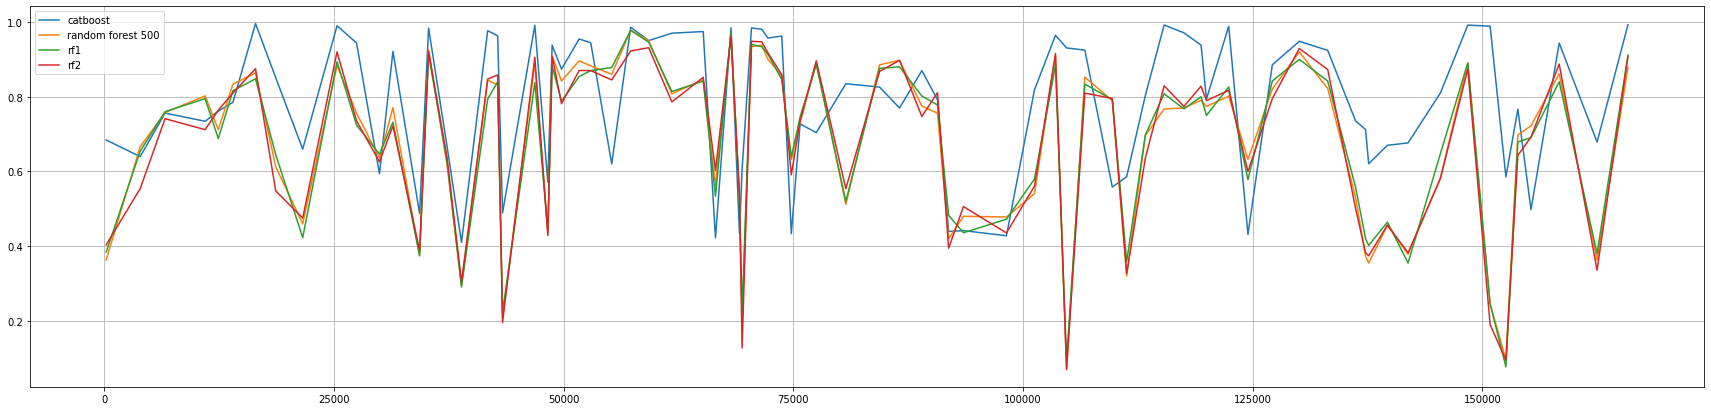

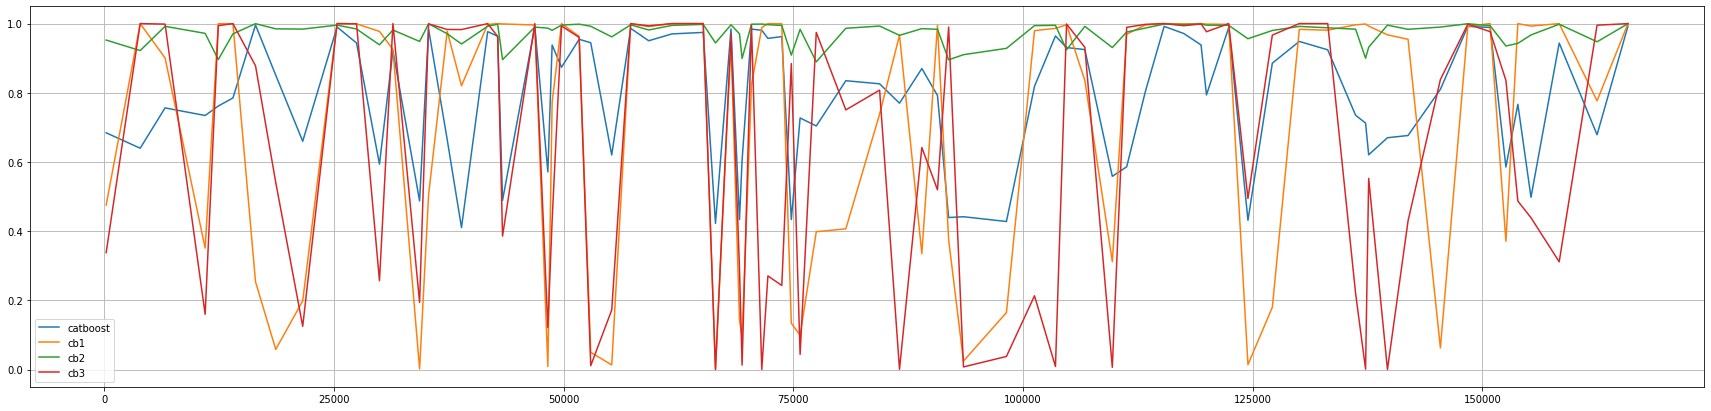

In [ ]:
idx = predict_data['catboost']>=0.4
predict_data[idx].iloc[0:4000:50][['catboost', 'random forest 500', 'rf1', 'rf2']].plot(figsize=(30, 7))
plt.grid();
predict_data[idx].iloc[0:4000:50][['catboost', 'cb1', 'cb2', 'cb3']].plot(figsize=(30, 7))
plt.grid();

## Блендинг над предсказаниями с PolynomialFeatures

In [ ]:
# !!! только для catboost-ов
predict_val = predict_val[['catboost', 'cb1', 'cb2', 'cb3', 'cb4', 'cb5']]
predict_data = predict_data[['catboost', 'cb1', 'cb2', 'cb3', 'cb4', 'cb5']]

In [ ]:
# Загрузим данные из файла
predict_val = pd.read_pickle('drive/MyDrive/Data/predict_val.zip')
y_val = pd.read_pickle('drive/MyDrive/Data/y_val.zip')
predict_data = pd.read_pickle('drive/MyDrive/Data/predict_data.zip')

In [ ]:
def poly_transform(data, degree=2):
    poly = PolynomialFeatures(degree=degree)
    poly_df = poly.fit_transform(data)
    poly_features = poly.get_feature_names_out(data.columns)
    predict_poly = pd.DataFrame(poly_df, columns=poly_features)
    predict_poly.drop('1', axis = 1, inplace=True)
    return predict_poly

In [ ]:
predict_poly_val = poly_transform(predict_val)

In [ ]:
# Обучим LogisticRegression на полученных предсказаниях
blender = LogisticRegression()
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500, 5000]
    }
]
clf = GridSearchCV(blender, param_grid = param_grid, cv = 2, verbose=True, n_jobs=-1)
blender = clf.fit(predict_poly_val, y_val)

In [ ]:
blender.best_estimator_

LogisticRegression(C=1.623776739188721, solver='liblinear')

In [ ]:
# Сохранение модели в файл
pd.to_pickle(blender, 'best_model.zip')

In [ ]:
# Простая логическая регрессия
blender = LogisticRegression(max_iter=5000)
blender.fit(predict_poly_val, y_val)

LogisticRegression(max_iter=5000)

In [ ]:
# Обучим RandomForest на полученных предсказаниях
blender = RandomForestClassifier(
    n_estimators = 1000, 
    random_state = 0xFEED, 
    max_depth = 25,
    min_samples_leaf = 1, # Для классификатора рекомендуют 1, для регрессии - 5
    n_jobs=-1
)
blender.fit(predict_poly_val, y_val)

RandomForestClassifier(max_depth=25, n_estimators=1000, n_jobs=-1,
                       random_state=65261)

In [ ]:
predict_data_poly = poly_transform(predict_data)

In [ ]:
# Подготовка ответа для Каггл
submission = pd.read_csv('drive/MyDrive/Data/sample_submission.csv', delimiter=',')
submission['isFraud'] = blender.predict_proba(predict_data_poly)[:,1] # you must predict a probability for the isFraud variable
submission.to_csv('poly_blender_logreg_rf1-5_cb1-5.csv', index=False)



---

Kaggle: 0.906649, 0.930168 ...

best 0.913484, 0.939870